In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process_example import *

df = pd.read_csv('gp_objects.csv')
display(df)
obj = sorted(df.obj_id.unique())

mjd   flux_ztfg   flux_ztfi   flux_ztfr  flux_error_ztfg  \
0      57983.231000  385.374906  440.341788  404.940209        29.250027   
1      57983.239778  382.559484  438.232033  402.502588        28.789575   
2      57983.248556  379.738177  436.119876  400.065220        28.332873   
3      57983.257333  376.910979  434.005567  397.628148        27.879986   
4      57983.266111  374.077886  431.889351  395.191413        27.430981   
...             ...         ...         ...         ...              ...   
73996  60652.513689   33.493383         NaN   40.961798         3.488673   
73997  60652.519801   33.463261         NaN   40.930338         3.842217   
73998  60652.525913   33.432509         NaN   40.895906         4.235472   
73999  60652.532025   33.401076         NaN   40.858402         4.657035   
74000  60652.538137   33.368917         NaN   40.817727         5.098662   

       flux_error_ztfi  flux_error_ztfr      type        obj_id         mjd_0  \
0            17.182907        24.797305  Kilonova     AT2017gfo  57983.231000   
1            16.890215        24.361032  Kilonova     AT2017gfo  57983.231000   
2            16.606597        23.927709  Kilonova     AT2017gfo  57983.231000   
3            16.332054        23.497397  Kilonova     AT2017gfo  57983.231000   
4            16.066587        23.070161  Kilonova     AT2017gfo  57983.231000   
...                ...              ...       ...           ...           ...   
73996              NaN         5.252959       IIb  ZTF24abvevzs  60646.432303   
73997              NaN         5.054402       IIb  ZTF24abvevzs  60646.432303   
73998              NaN         4.909244       IIb  ZTF24abvevzs  60646.432303   
73999              NaN         4.823773       IIb  ZTF24abvevzs  60646.432303   
74000              NaN         4.802653       IIb  ZTF24abvevzs  60646.432303   

       ...   mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
0      ...  17.435291    -15.778388        0.082408  17.381523    -15.832157   
1      ...  17.443253    -15.770427        0.081707  17.388078    -15.825601   
2      ...  17.451289    -15.762390        0.081009  17.394673    -15.819007   
3      ...  17.459403    -15.754277        0.080312  17.401307    -15.812372   
4      ...  17.467595    -15.746085        0.079617  17.407981    -15.805698   
...    ...        ...           ...             ...        ...           ...   
73996  ...  20.087602    -15.921953        0.113090  19.869052    -16.140503   
73997  ...  20.088579    -15.920976        0.124663  19.869887    -16.139669   
73998  ...  20.089578    -15.919978        0.137549  19.870800    -16.138755   
73999  ...  20.090599    -15.918957        0.151382  19.871797    -16.137759   
74000  ...  20.091645    -15.917911        0.165897  19.872878    -16.136678   

       mag_error_ztfr   mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
0            0.066487  17.290525    -15.923154        0.042367  0.000000  
1            0.065713  17.295740    -15.917940        0.041846  0.008778  
2            0.064937  17.300985    -15.912694        0.041343  0.017556  
3            0.064160  17.306262    -15.907418        0.040857  0.026333  
4            0.063382  17.311569    -15.902111        0.040390  0.035111  
...               ...        ...           ...             ...       ...  
73996        0.139235        NaN           NaN             NaN  6.081386  
73997        0.134075        NaN           NaN             NaN  6.087498  
73998        0.130334        NaN           NaN             NaN  6.093610  
73999        0.128183        NaN           NaN             NaN  6.099721  
74000        0.127749        NaN           NaN             NaN  6.105833  

[74001 rows x 21 columns]

In [2]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd' and 'abs' not in column:
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['t'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['t'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [3]:
def cut_data(df, obj_id, cutoff, plot=True):
    obj_model = df[df['obj_id'] == obj_id]
    if plot:
        f, ax = plot_gp(obj_model)
        ax.axvline(cutoff, color='black', linestyle='--', label='Cutoff')
        plt.show()

    obj_model = obj_model[obj_model['t'] < cutoff]
    combined_df = pd.concat([df[df['obj_id'] != obj_id], obj_model])
    return combined_df

In [4]:
obj[1+51]

'ZTF22abmsaxp'

In [5]:
df[df['obj_id'] == obj[40]]

mjd  flux_ztfg  flux_ztfi  flux_ztfr  flux_error_ztfg  \
40000  59390.264849  53.224508        NaN  42.856080         6.532327   
40001  59390.280858  53.187907        NaN  42.830382         6.596347   
40002  59390.296867  53.105095        NaN  42.791406         6.799717   
40003  59390.312875  52.979612        NaN  42.737942         7.123358   
40004  59390.328884  52.814757        NaN  42.668918         7.545048   
...             ...        ...        ...        ...              ...   
40995  59406.193465  24.024151        NaN  26.041101        15.618604   
40996  59406.209474  24.068046        NaN  26.104938        15.482465   
40997  59406.225483  24.099553        NaN  26.151804        15.383847   
40998  59406.241491  24.118520        NaN  26.180697        15.324113   
40999  59406.257500  24.124852        NaN  26.190567        15.304106   

       flux_error_ztfi  flux_error_ztfr         type        obj_id  \
40000              NaN         5.396206  Ib/c;Ib-pec  ZTF21abhywxv   
40001              NaN         5.381265  Ib/c;Ib-pec  ZTF21abhywxv   
40002              NaN         5.549125  Ib/c;Ib-pec  ZTF21abhywxv   
40003              NaN         5.875878  Ib/c;Ib-pec  ZTF21abhywxv   
40004              NaN         6.328525  Ib/c;Ib-pec  ZTF21abhywxv   
...                ...              ...          ...           ...   
40995              NaN         6.434541  Ib/c;Ib-pec  ZTF21abhywxv   
40996              NaN         5.892925  Ib/c;Ib-pec  ZTF21abhywxv   
40997              NaN         5.460252  Ib/c;Ib-pec  ZTF21abhywxv   
40998              NaN         5.175102  Ib/c;Ib-pec  ZTF21abhywxv   
40999              NaN         5.073936  Ib/c;Ib-pec  ZTF21abhywxv   

              mjd_0  ...   mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  \
40000  59390.264849  ...  19.584721    -17.177374        0.133254  19.819969   
40001  59390.264849  ...  19.585468    -17.176627        0.134653  19.820620   
40002  59390.264849  ...  19.587160    -17.174936        0.139021  19.821609   
40003  59390.264849  ...  19.589728    -17.172367        0.145982  19.822966   
40004  59390.264849  ...  19.593112    -17.168983        0.155107  19.824721   
...             ...  ...        ...           ...             ...        ...   
40995  59390.264849  ...  20.448380    -16.313715        0.705860  20.360852   
40996  59390.264849  ...  20.446398    -16.315697        0.698431  20.358193   
40997  59390.264849  ...  20.444978    -16.317118        0.693075  20.356246   
40998  59390.264849  ...  20.444123    -16.317972        0.689841  20.355047   
40999  59390.264849  ...  20.443838    -16.318257        0.688760  20.354638   

       abs_mag_ztfr  mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi  \
40000    -16.942126        0.136710       NaN           NaN             NaN   
40001    -16.941475        0.136413       NaN           NaN             NaN   
40002    -16.940487        0.140797       NaN           NaN             NaN   
40003    -16.939129        0.149274       NaN           NaN             NaN   
40004    -16.937374        0.161033       NaN           NaN             NaN   
...             ...             ...       ...           ...             ...   
40995    -16.401244        0.268276       NaN           NaN             NaN   
40996    -16.403902        0.245094       NaN           NaN             NaN   
40997    -16.405849        0.226692       NaN           NaN             NaN   
40998    -16.407048        0.214616       NaN           NaN             NaN   
40999    -16.407457        0.210341       NaN           NaN             NaN   

               t  
40000   0.000000  
40001   0.016009  
40002   0.032017  
40003   0.048026  
40004   0.064035  
...          ...  
40995  15.928616  
40996  15.944625  
40997  15.960633  
40998  15.976642  
40999  15.992651  

[1000 rows x 21 columns]

In [6]:
df[df['obj_id'] == obj[7]].describe()

mjd    flux_ztfg  flux_ztfi    flux_ztfr  flux_error_ztfg  \
count   1000.000000  1000.000000        0.0  1000.000000      1000.000000   
mean   58597.816117   183.240171        NaN   159.572482        16.340975   
std        8.359731   118.369048        NaN   109.834246         4.714176   
min    58583.358345    37.237861        NaN    25.213199         4.146844   
25%    58590.587231    69.404153        NaN    51.971791        12.950148   
50%    58597.816117   155.415815        NaN   131.196179        16.746612   
75%    58605.045003   300.261026        NaN   276.223232        20.435642   
max    58612.273889   378.976388        NaN   327.480817        23.302721   

       flux_error_ztfi  flux_error_ztfr         mjd_0    redshift  \
count              0.0      1000.000000  1.000000e+03  1000.00000   
mean               NaN        19.957125  5.858336e+04     0.05469   
std                NaN         7.372145  7.279598e-12     0.00000   
min                NaN         4.663951  5.858336e+04     0.05469   
25%                NaN        13.819034  5.858336e+04     0.05469   
50%                NaN        19.954346  5.858336e+04     0.05469   
75%                NaN        23.725766  5.858336e+04     0.05469   
max                NaN        34.083335  5.858336e+04     0.05469   

          mag_ztfg  abs_mag_ztfg  mag_error_ztfg     mag_ztfr  abs_mag_ztfr  \
count  1000.000000   1000.000000     1000.000000  1000.000000   1000.000000   
mean     18.527526    -18.481901        0.164905    18.743734    -18.265694   
std       0.840248      0.840248        0.148486     0.951484      0.951484   
min      17.453470    -19.555958        0.046161    17.612035    -19.397392   
25%      17.706253    -19.303175        0.067068    17.796850    -19.212578   
50%      18.421263    -18.588164        0.089243    18.605198    -18.404229   
75%      19.296538    -17.712889        0.237520    19.610583    -17.398844   
max      19.972538    -17.036889        0.577762    20.395930    -16.613497   

       mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi            t  
count     1000.000000       0.0           0.0             0.0  1000.000000  
mean         0.261023       NaN           NaN             NaN    14.457772  
std          0.232465       NaN           NaN             NaN     8.359731  
min          0.043288       NaN           NaN             NaN     0.000000  
25%          0.074516       NaN           NaN             NaN     7.228886  
50%          0.147170       NaN           NaN             NaN    14.457772  
75%          0.417071       NaN           NaN             NaN    21.686658  
max          0.857379       NaN           NaN             NaN    28.915544

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


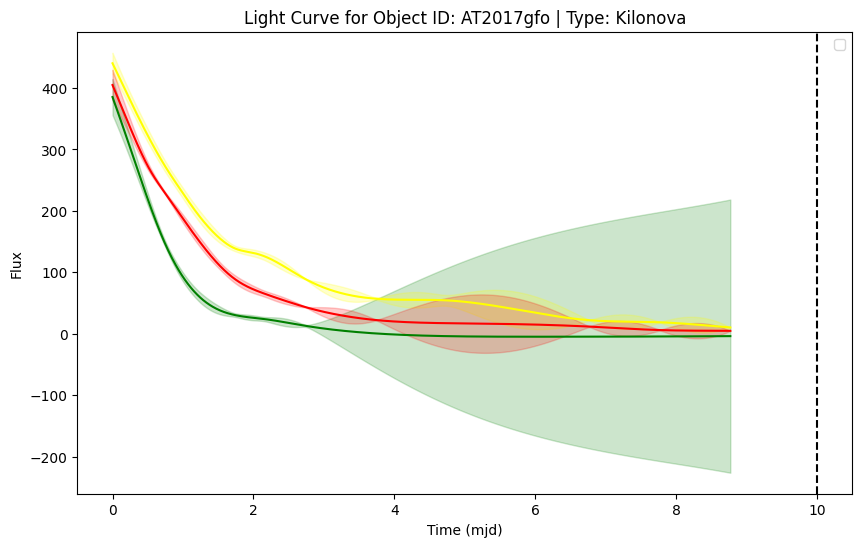

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


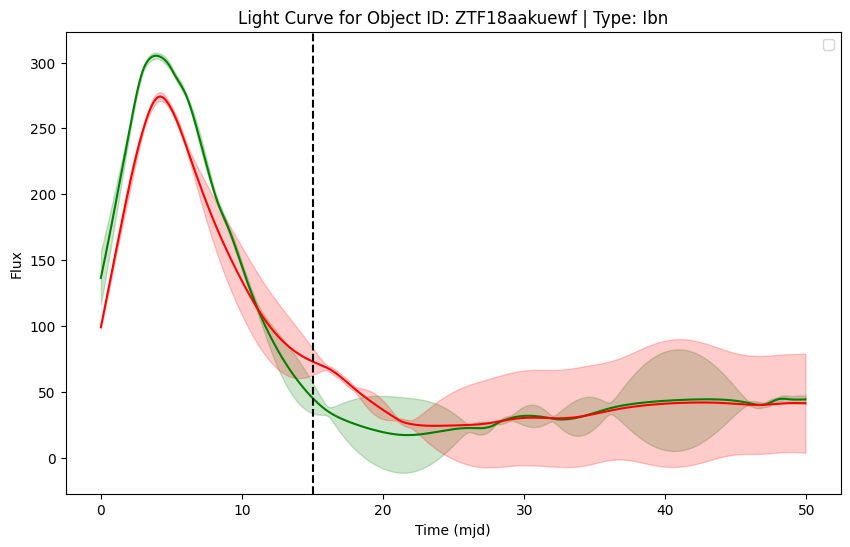

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


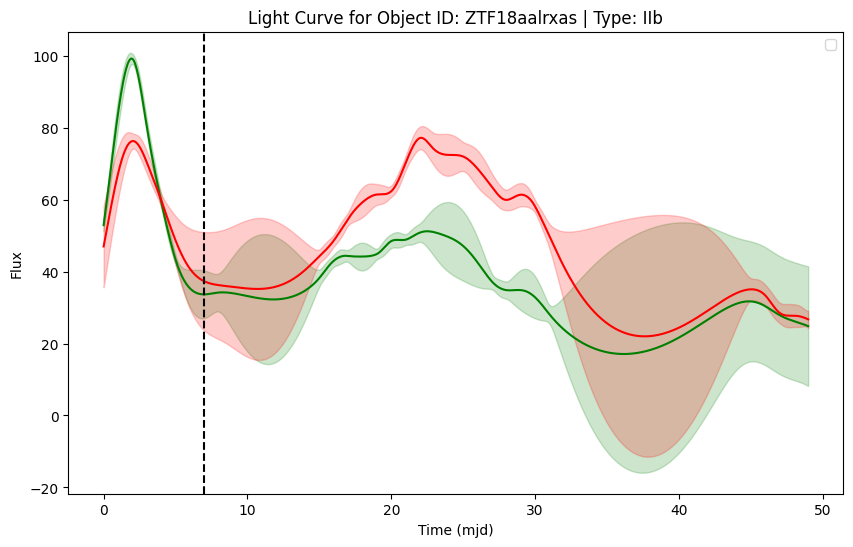

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


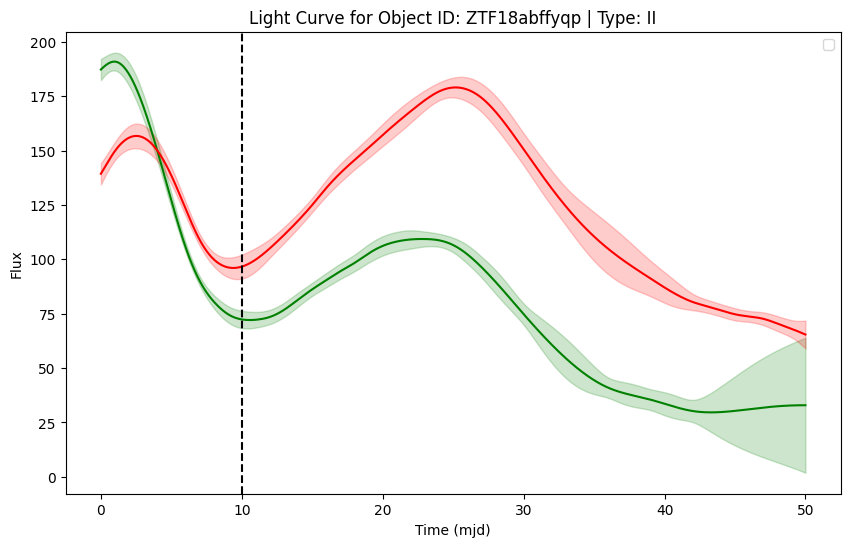

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


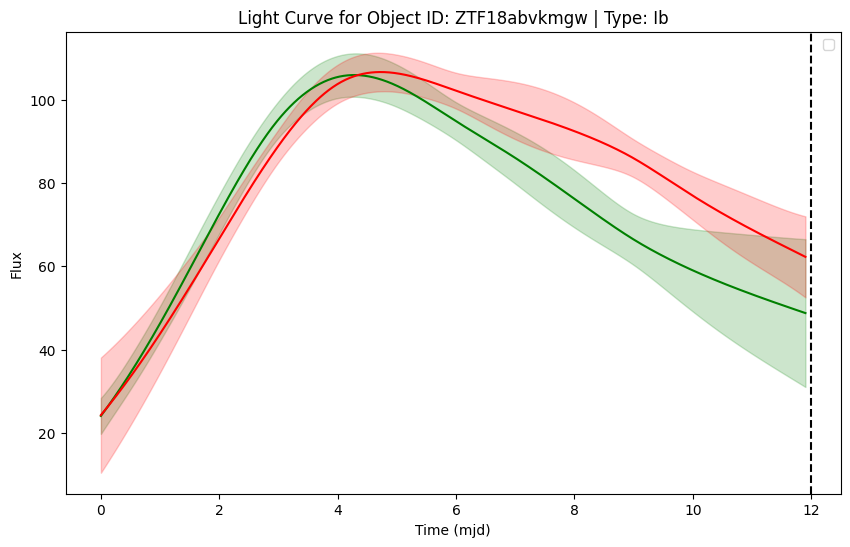

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


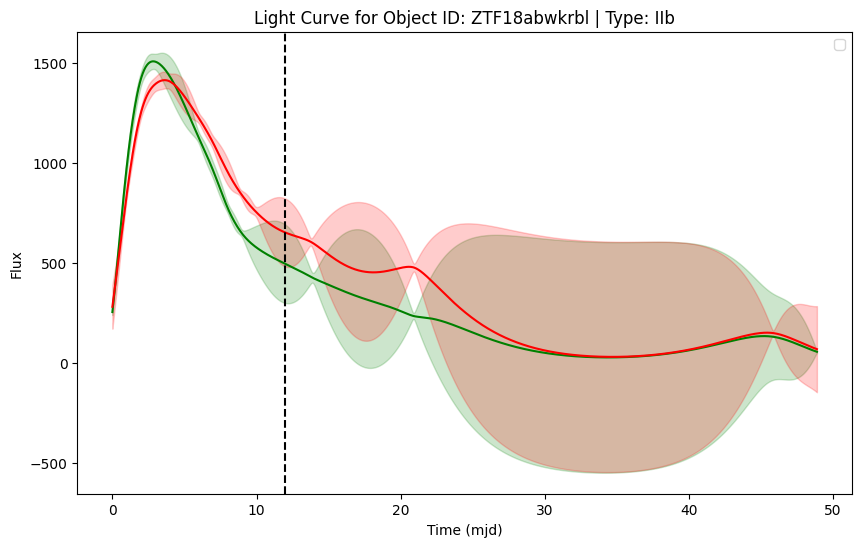

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


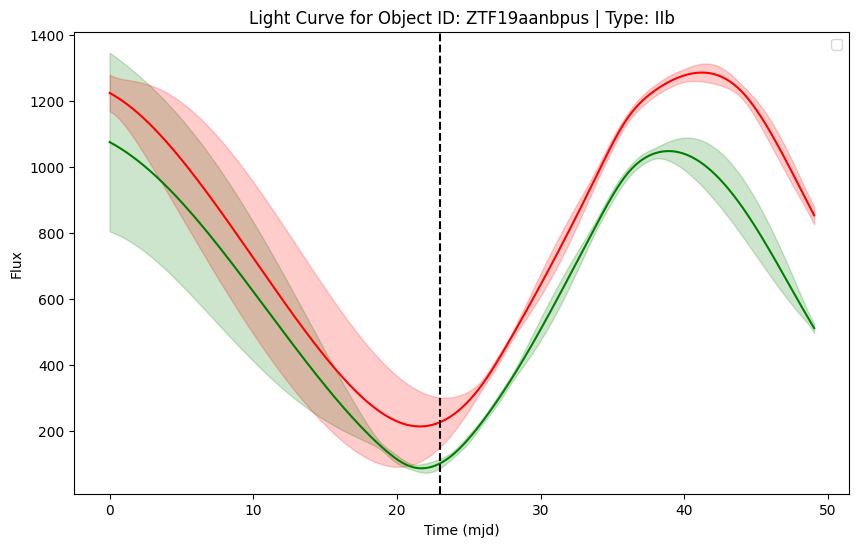

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


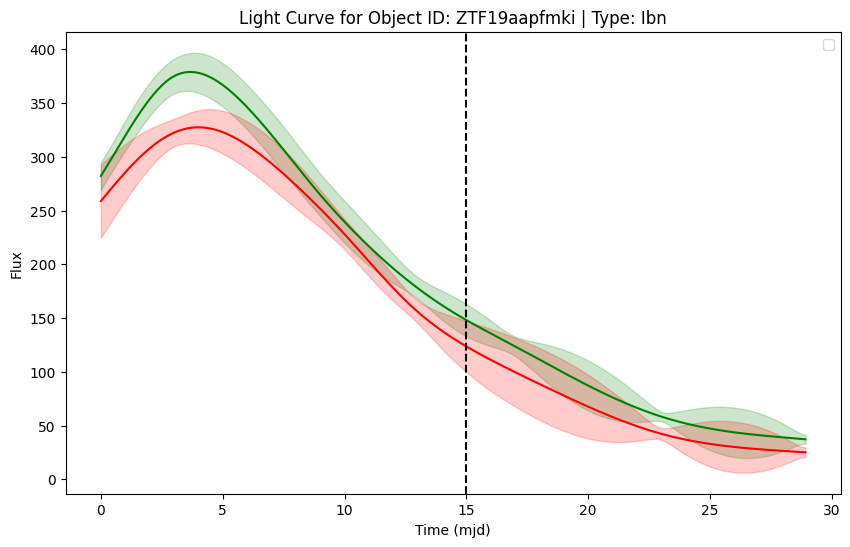

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


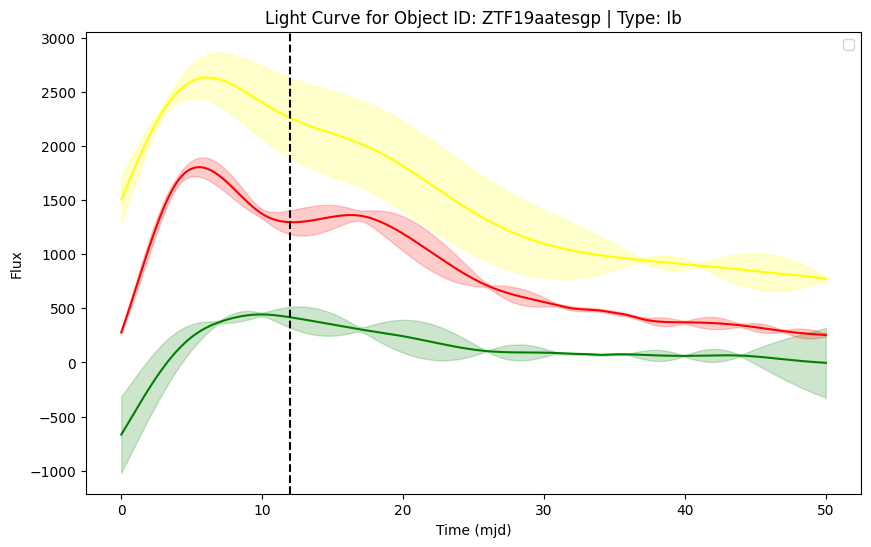

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


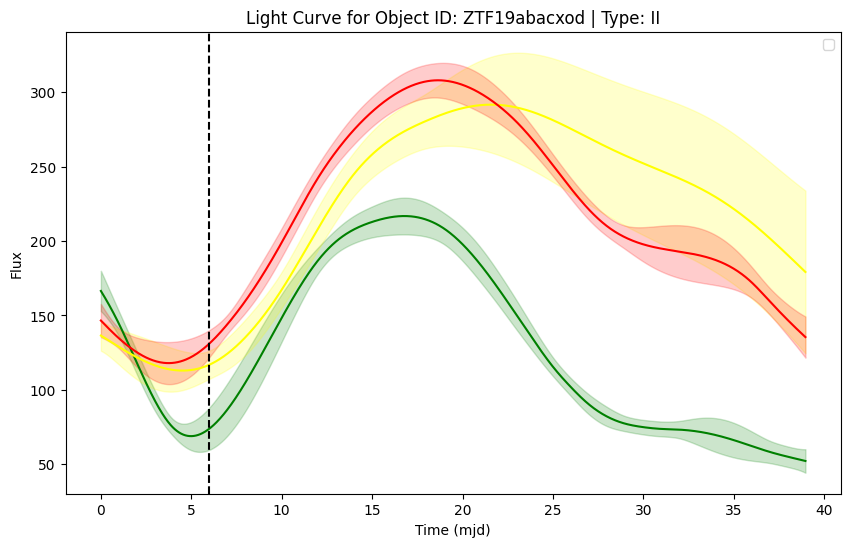

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


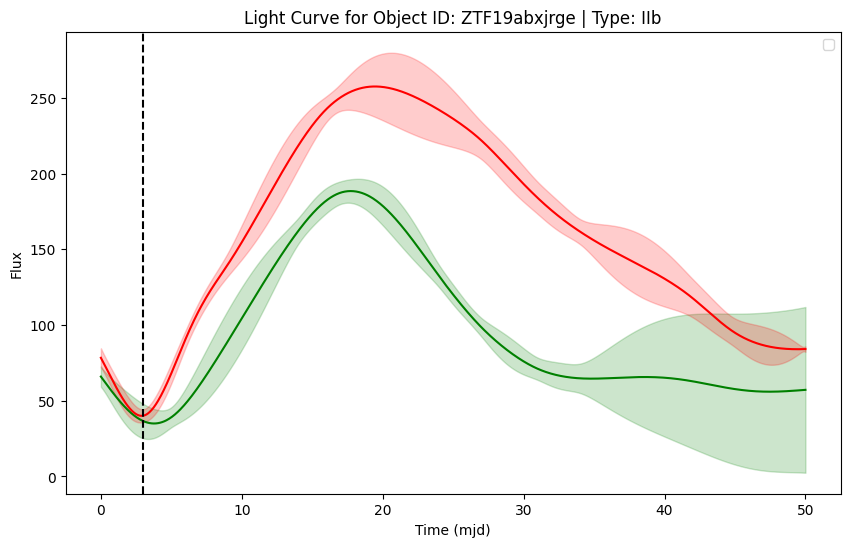

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


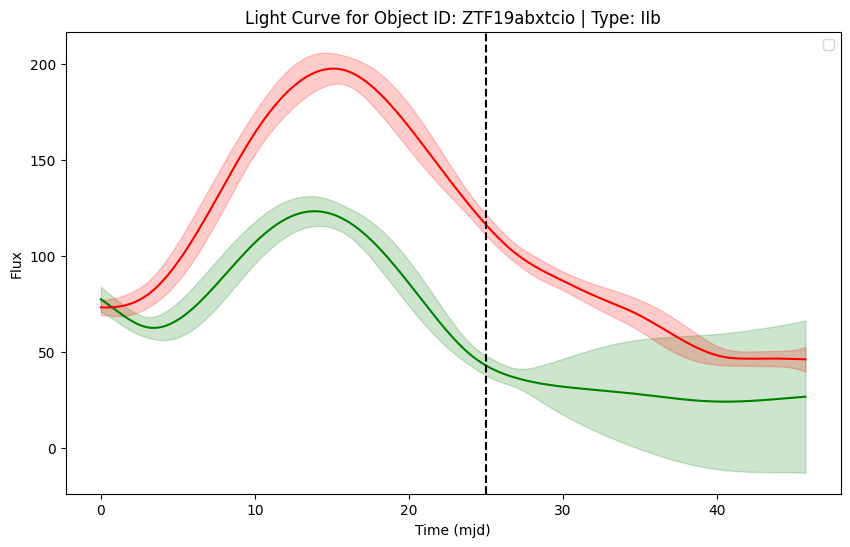

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


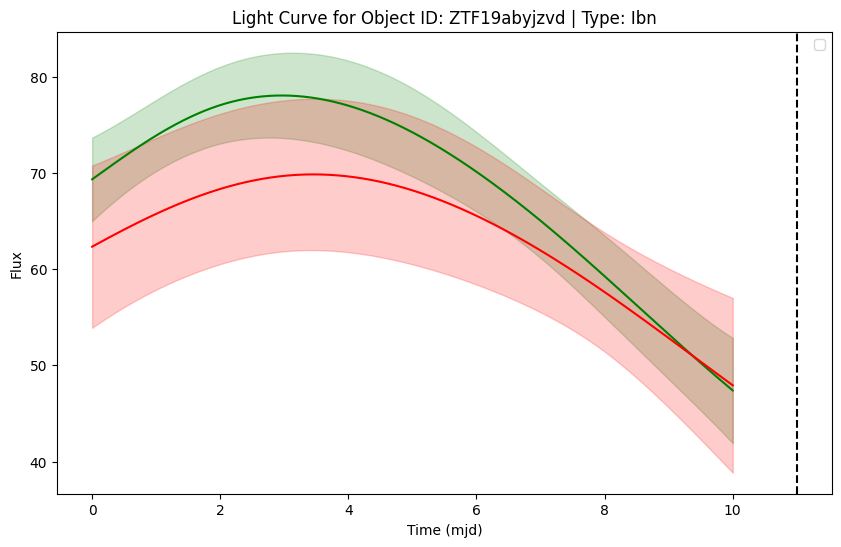

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


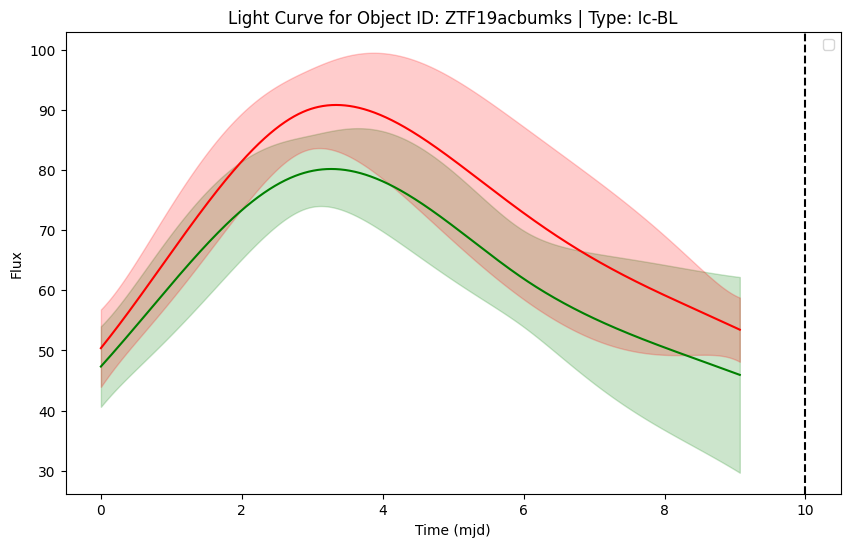

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


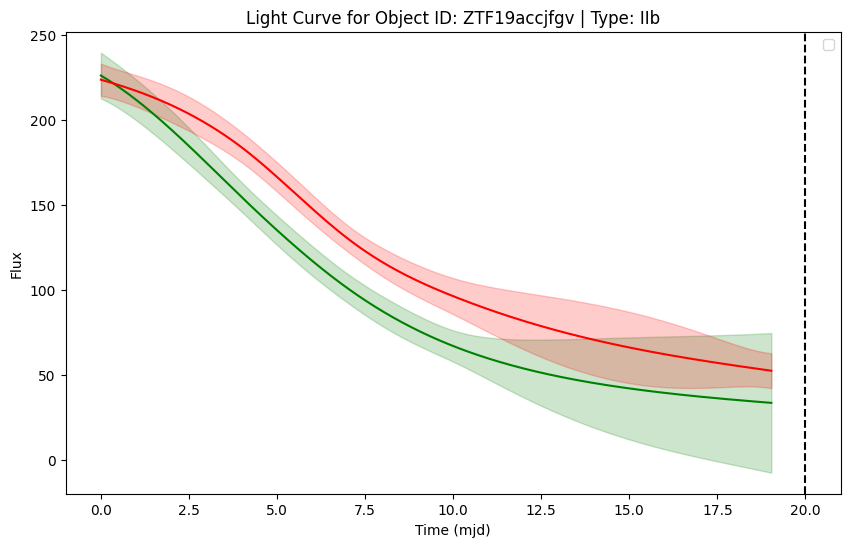

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


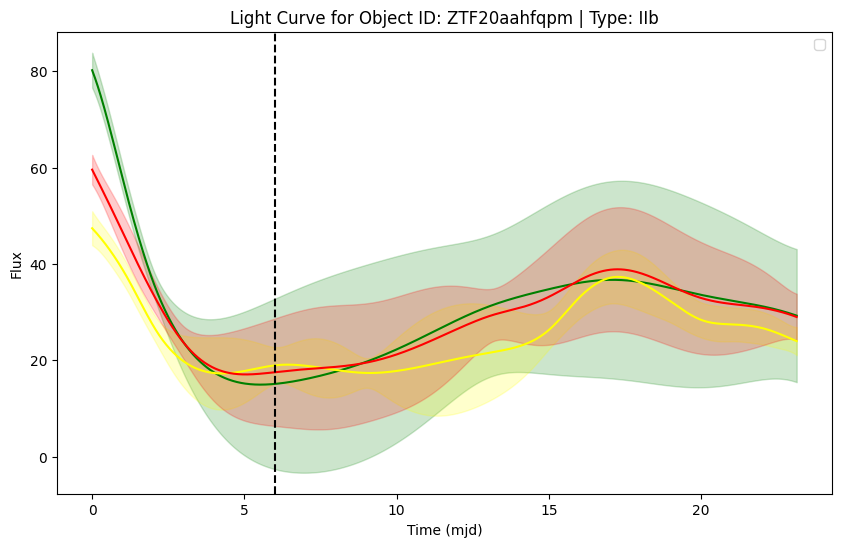

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


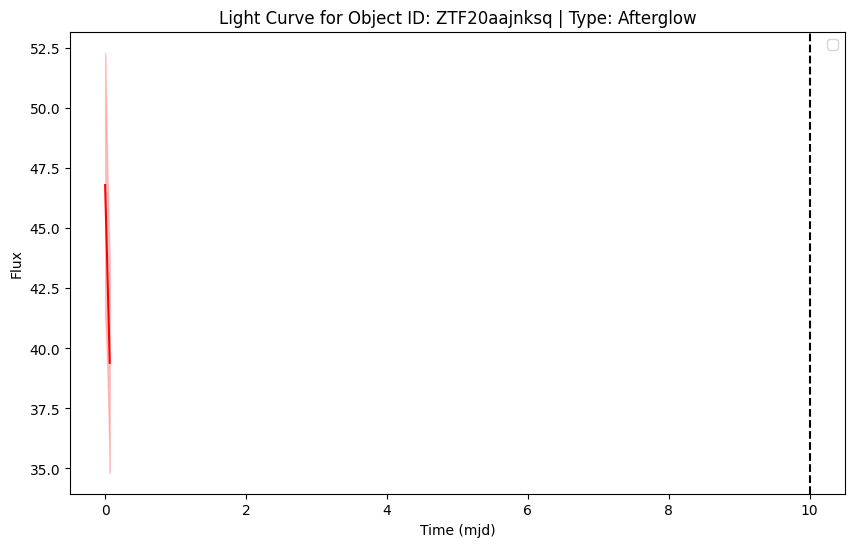

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


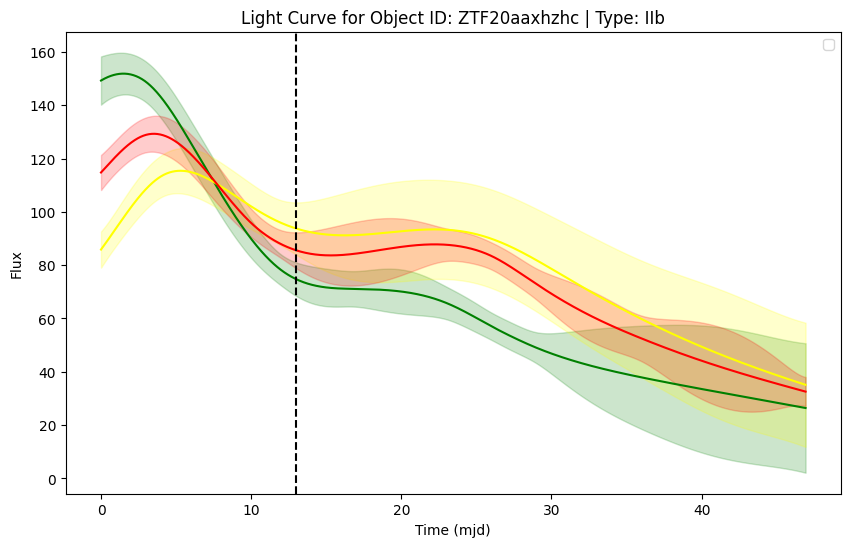

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


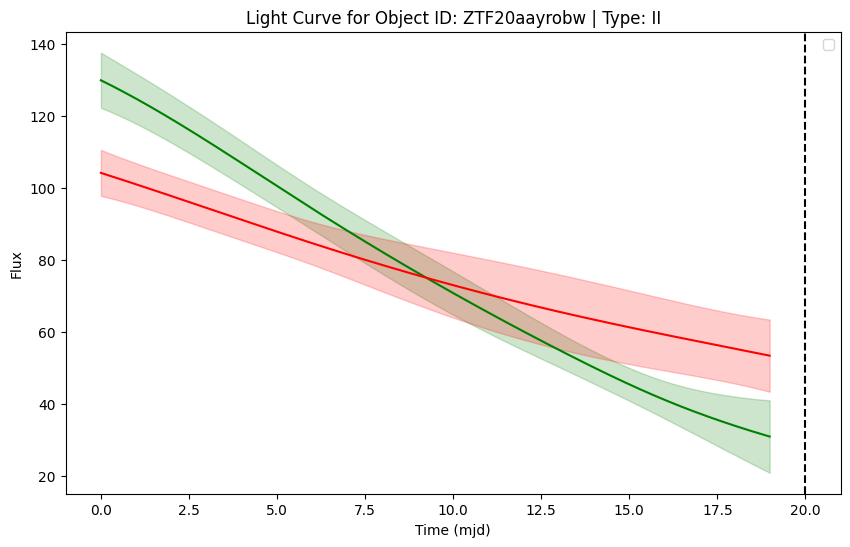

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


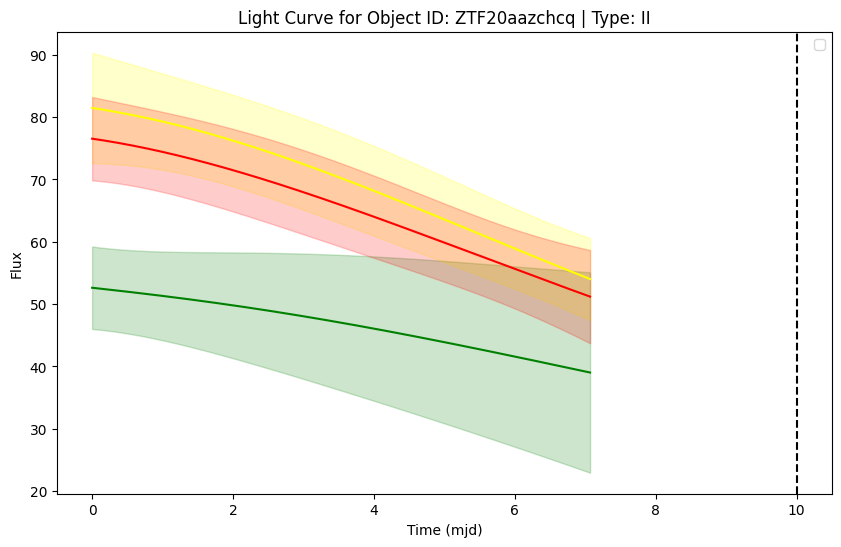

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


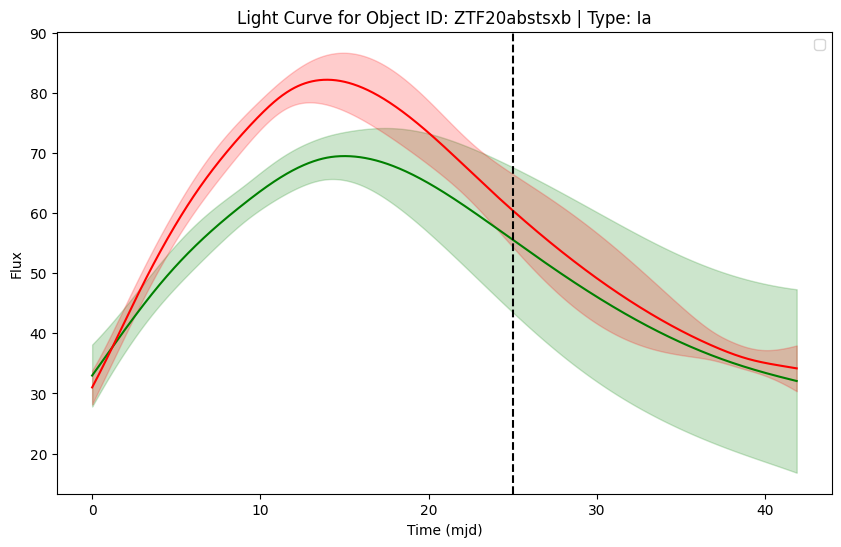

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


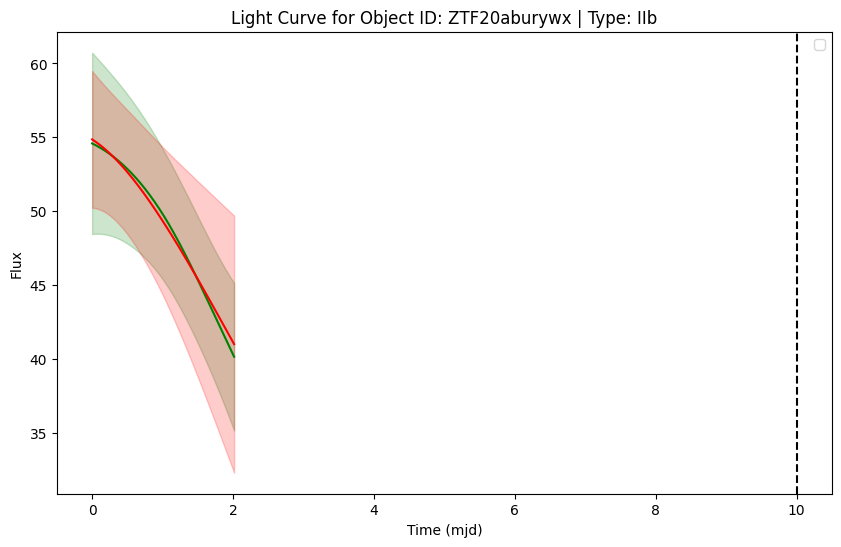

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


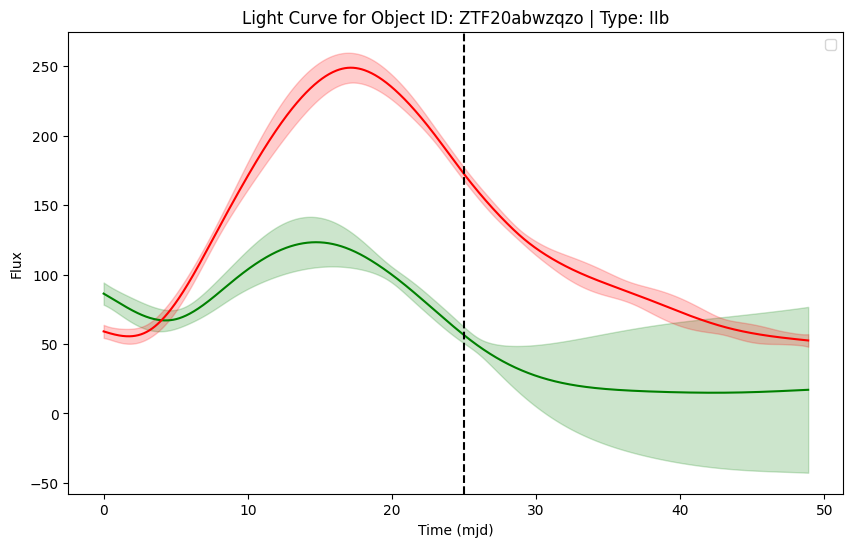

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


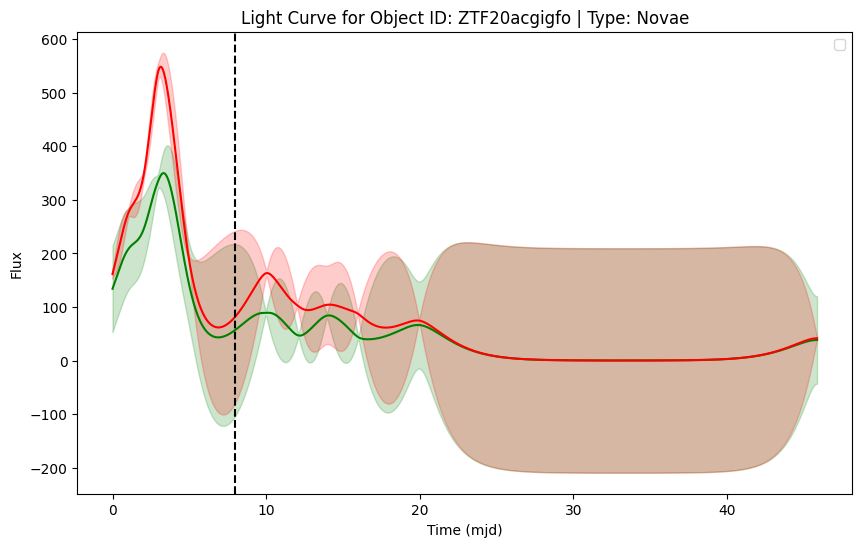

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


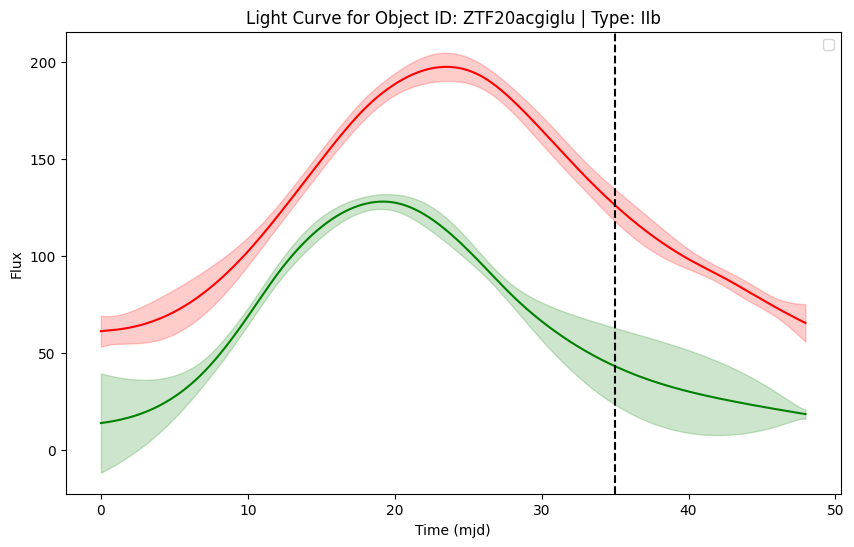

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


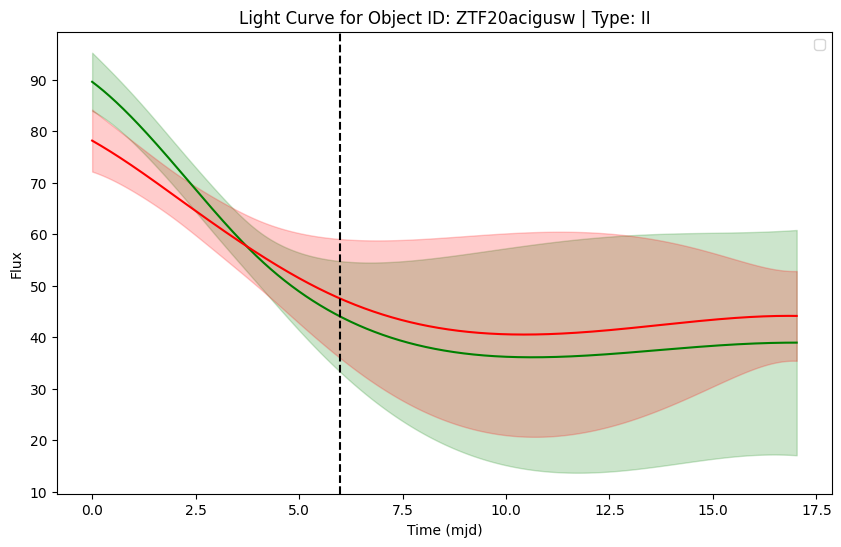

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


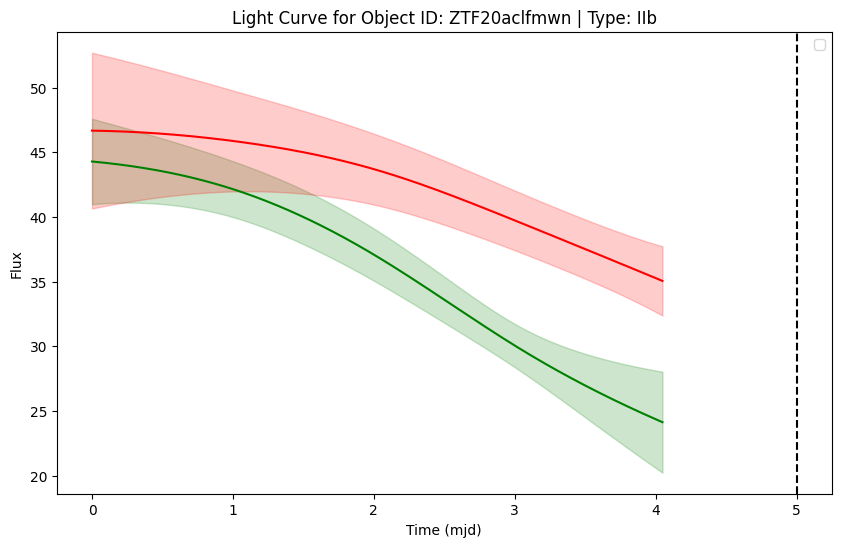

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


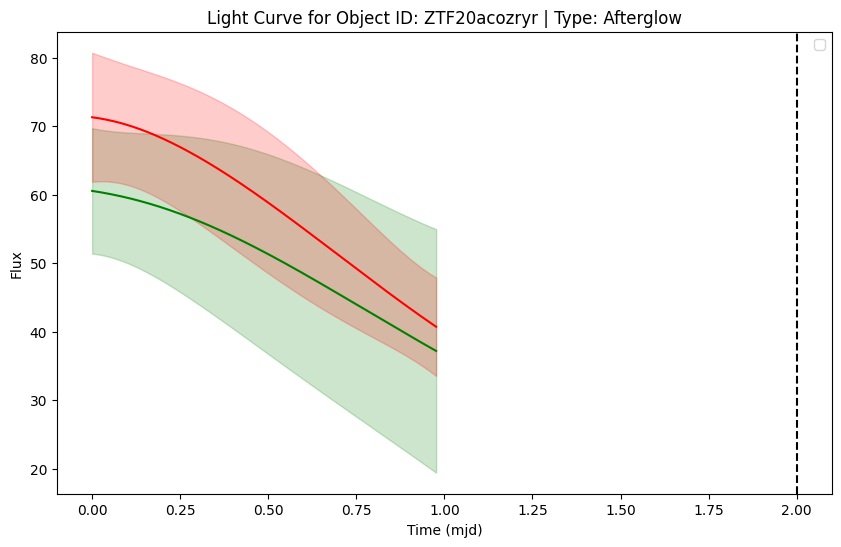

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


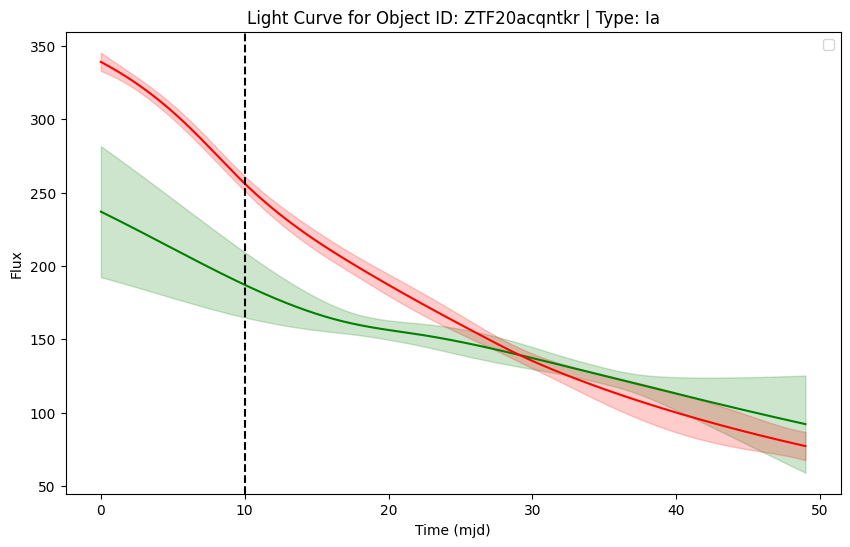

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


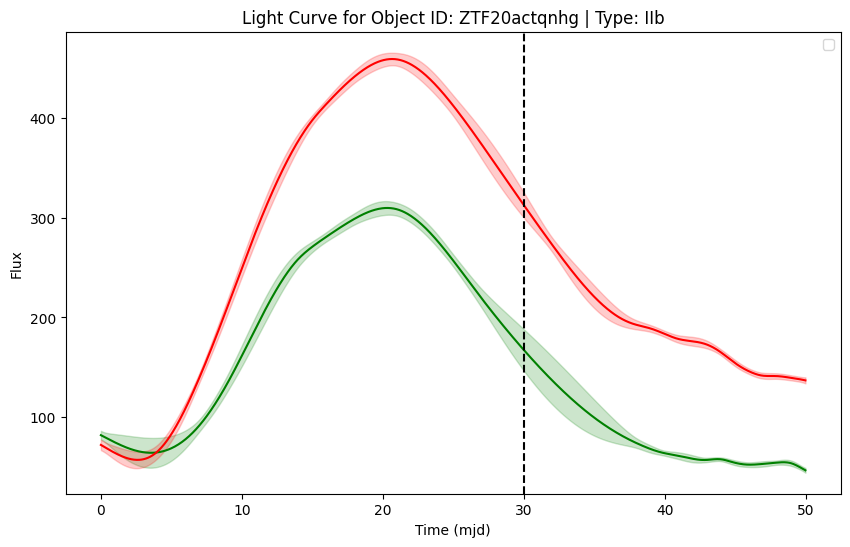

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


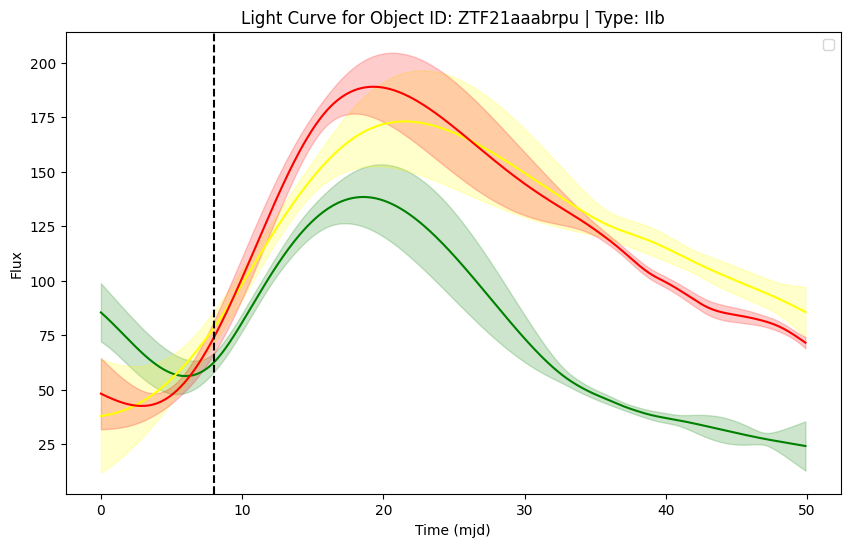

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


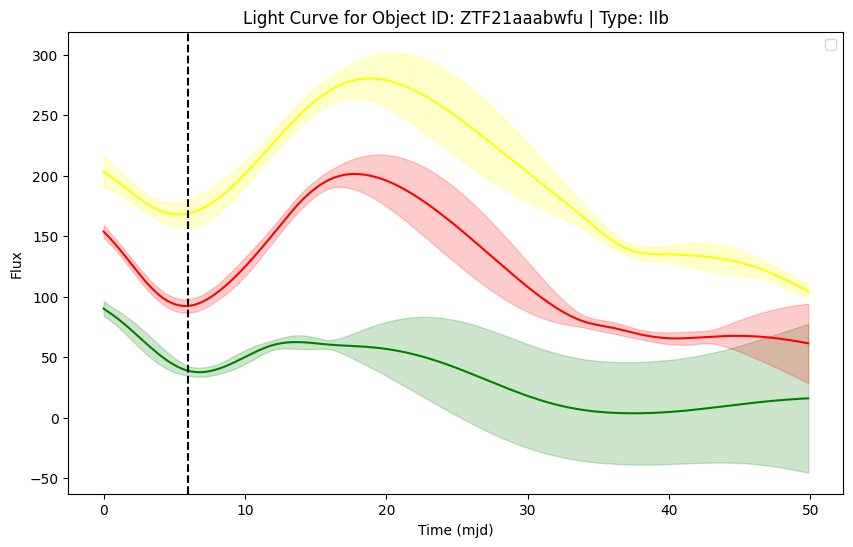

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


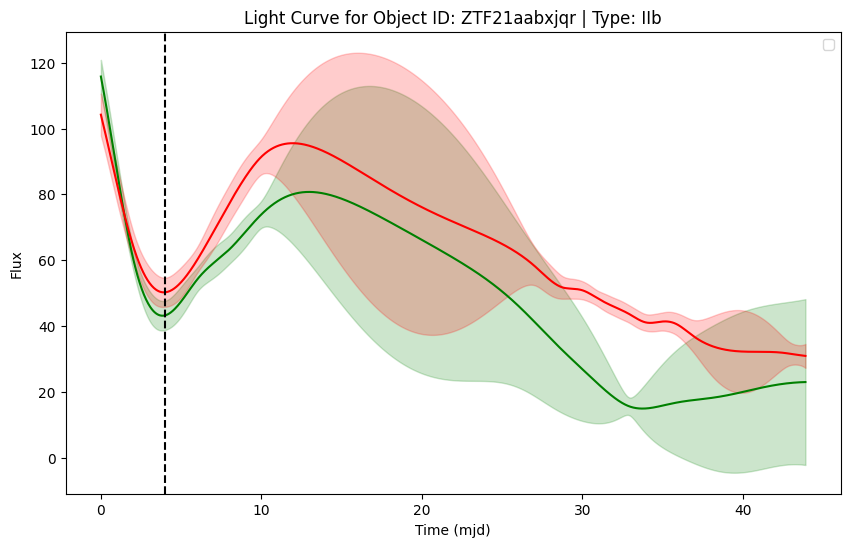

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


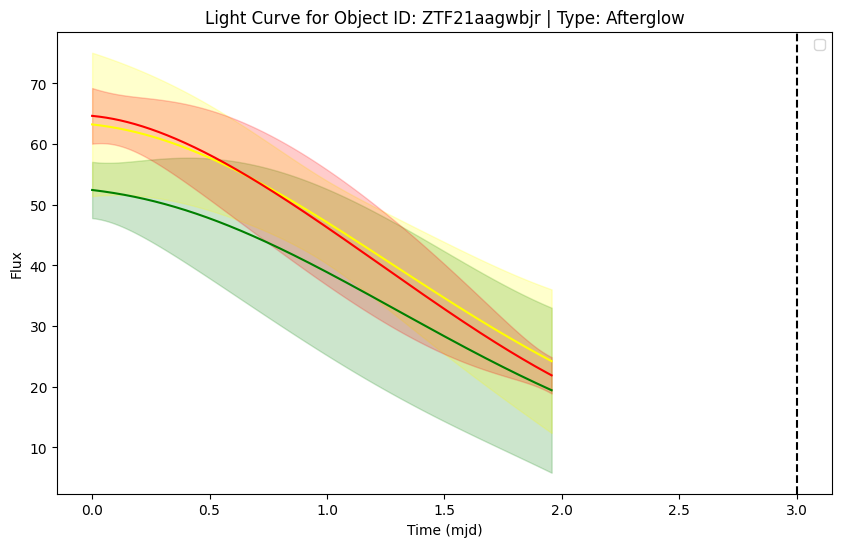

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


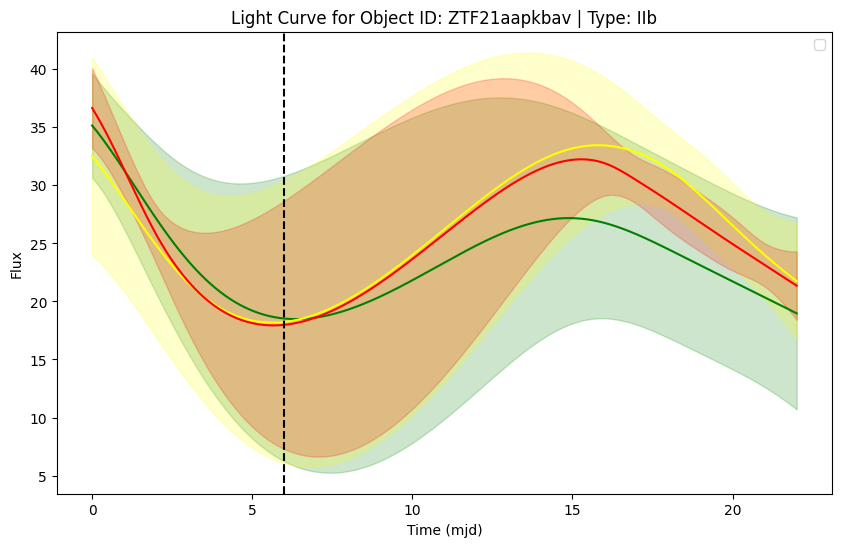

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


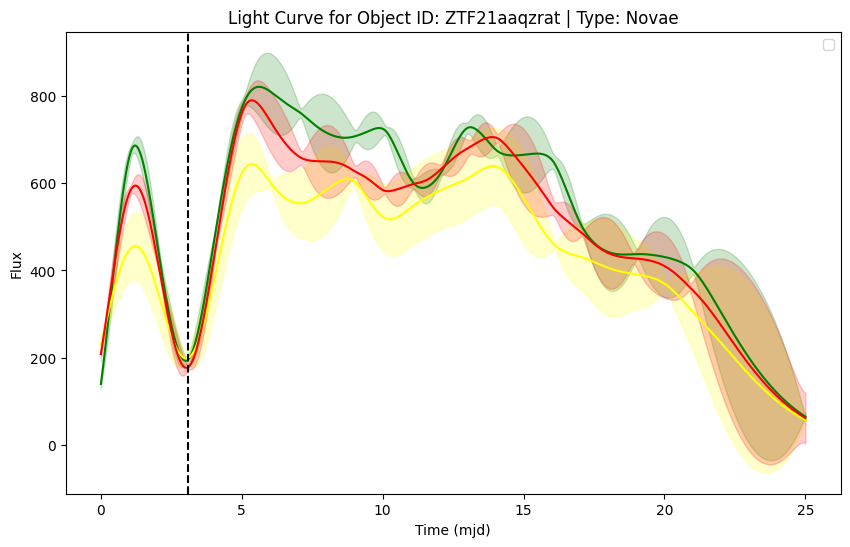

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


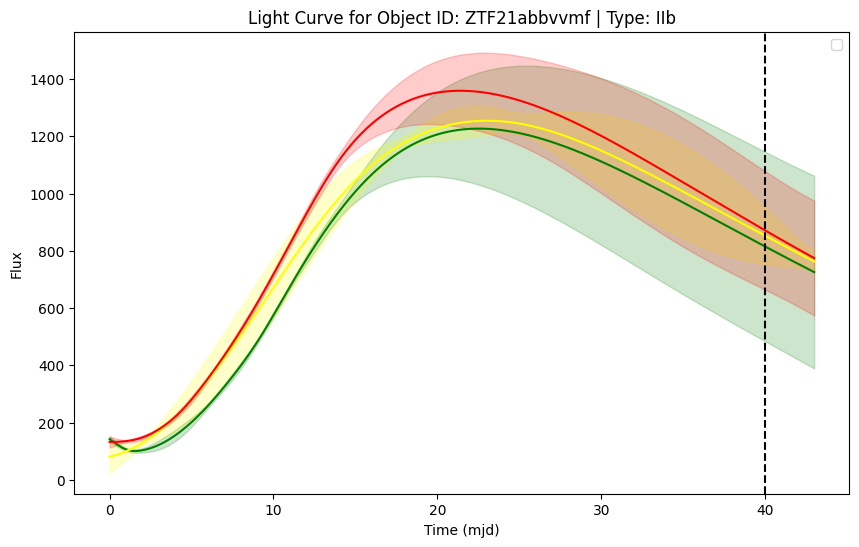

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


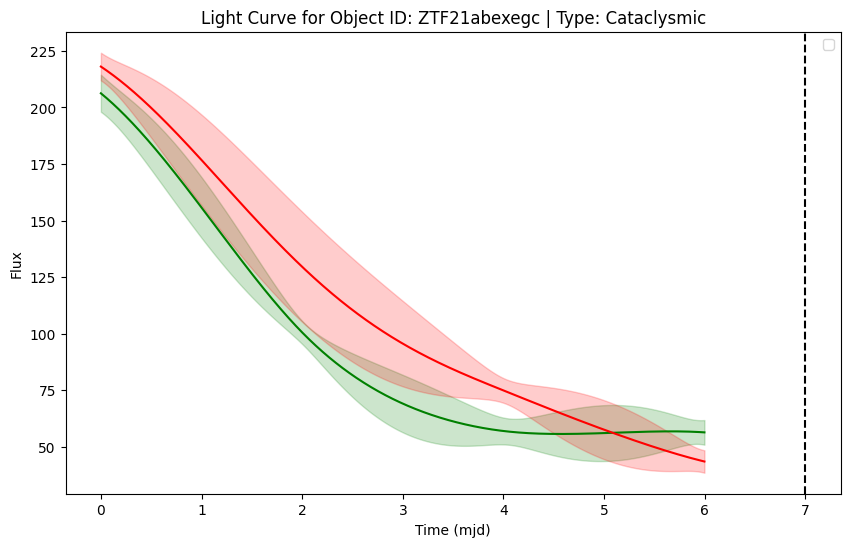

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


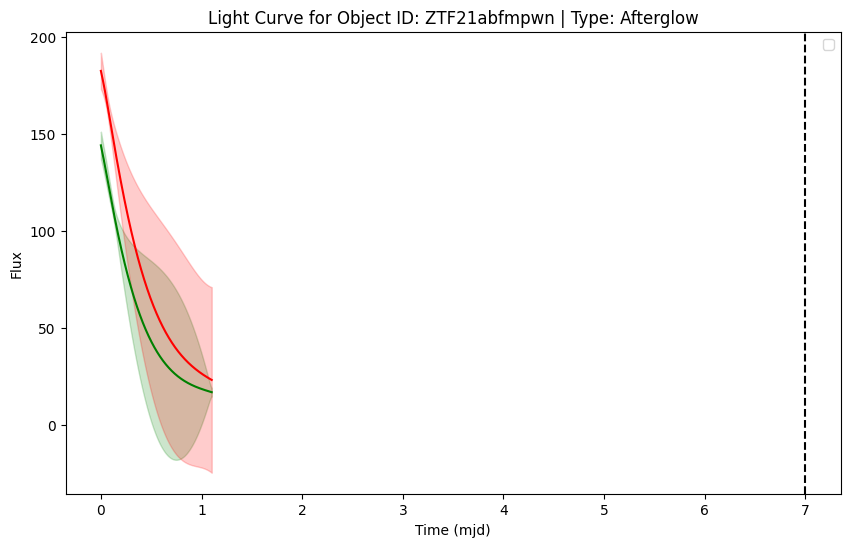

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


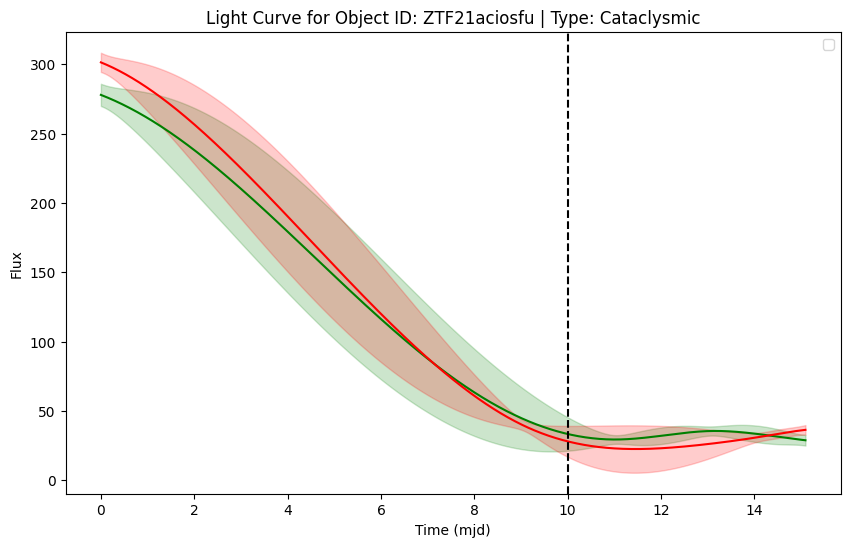

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


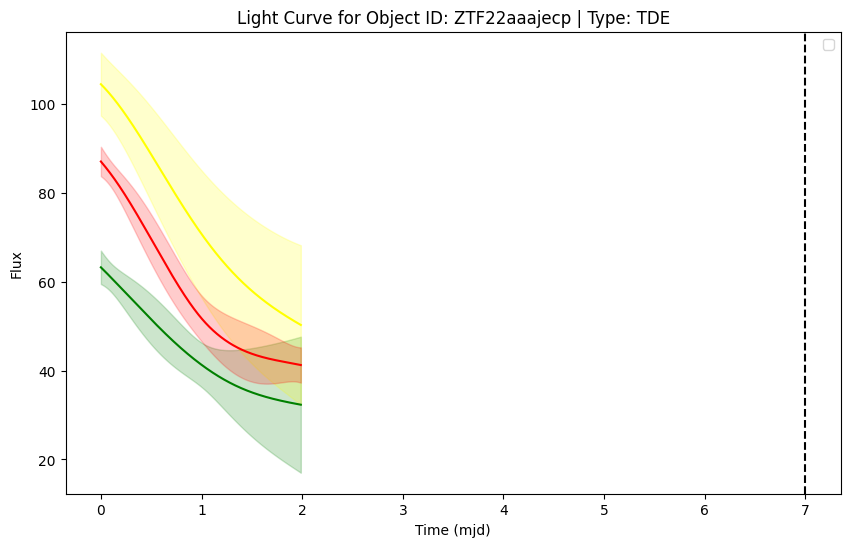

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


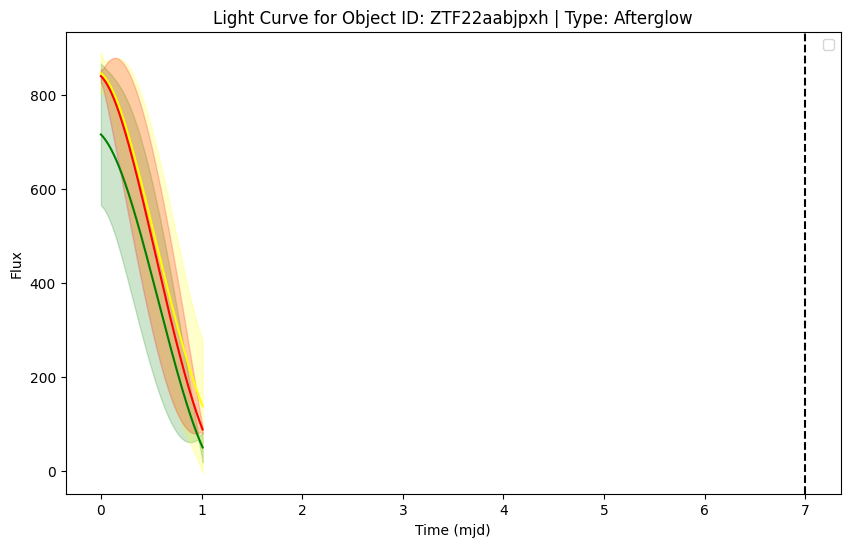

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


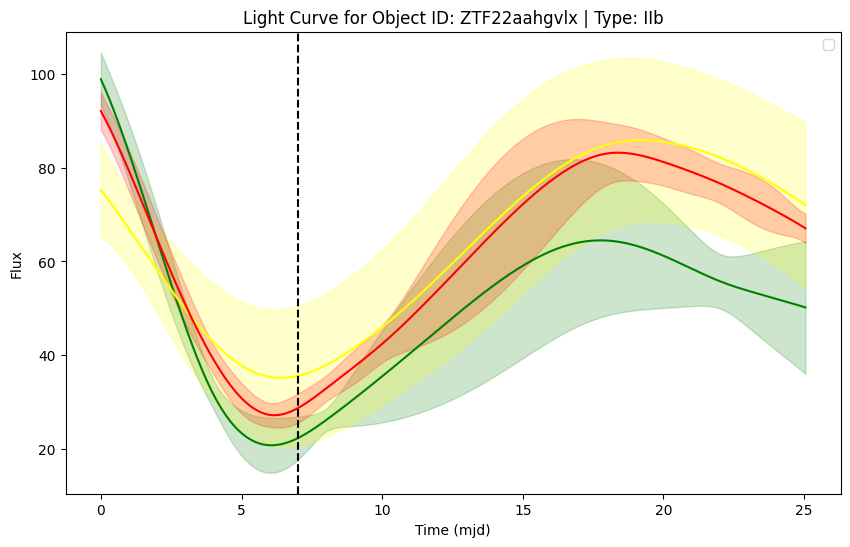

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


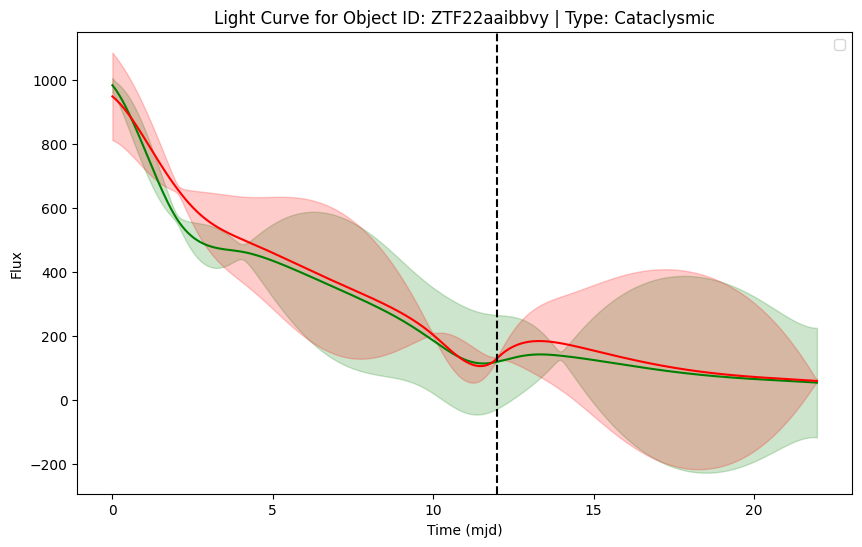

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


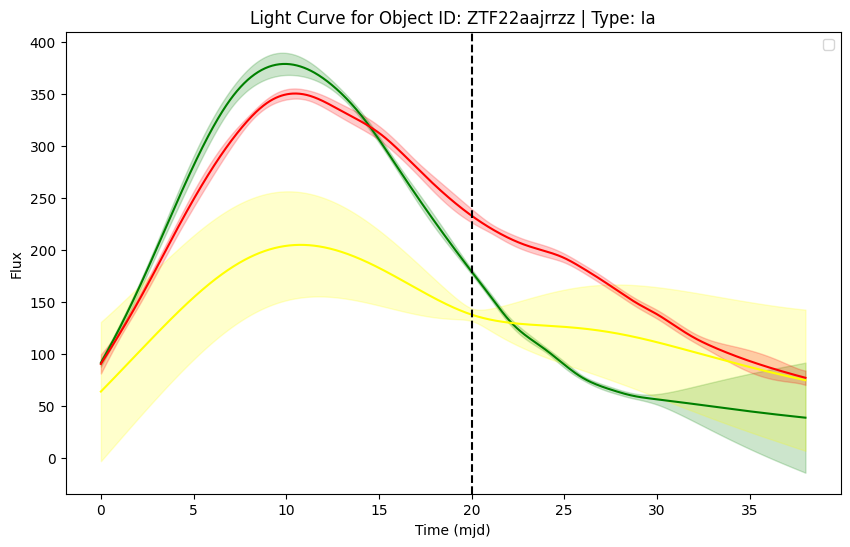

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


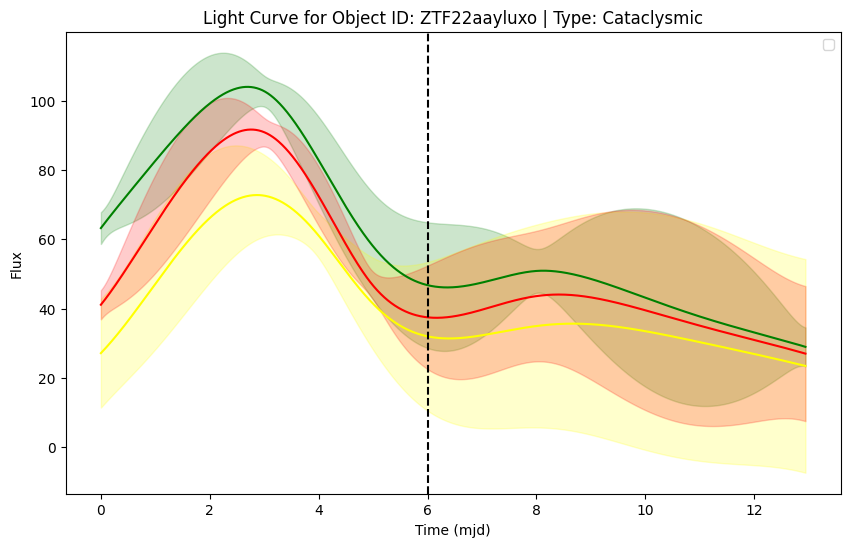

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


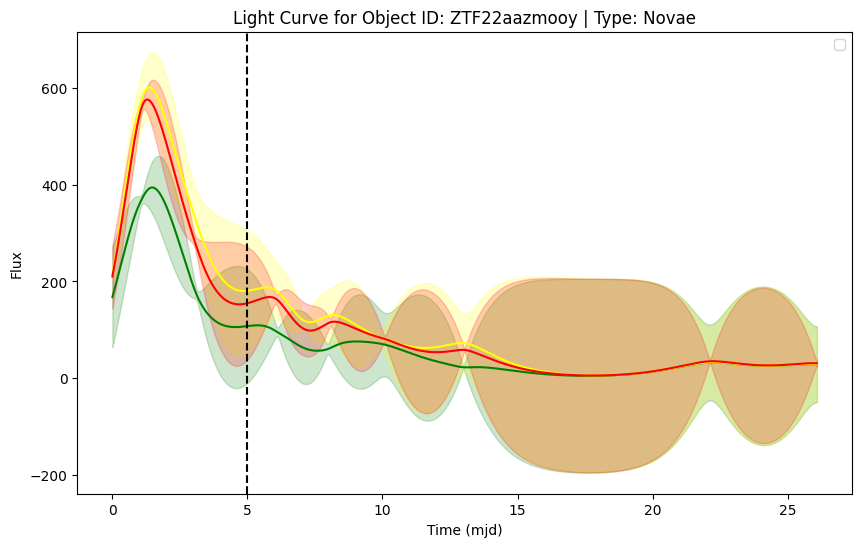

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


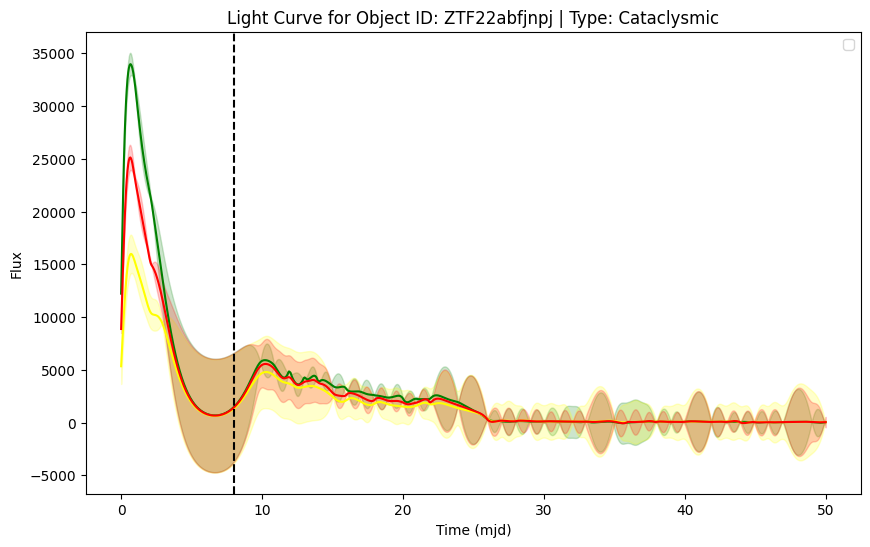

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


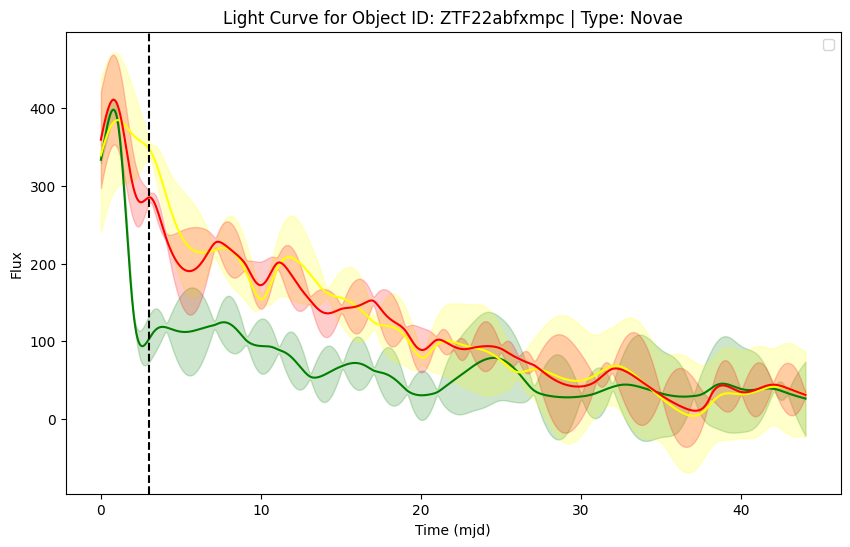

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


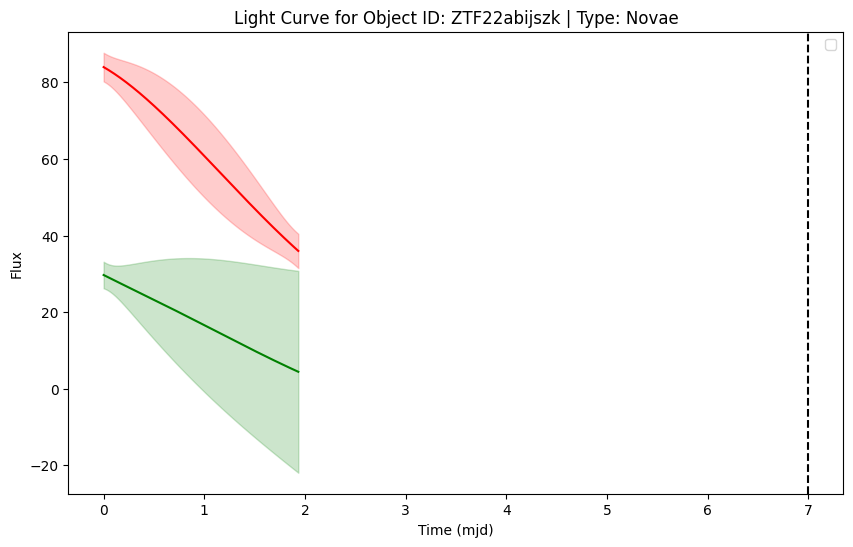

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


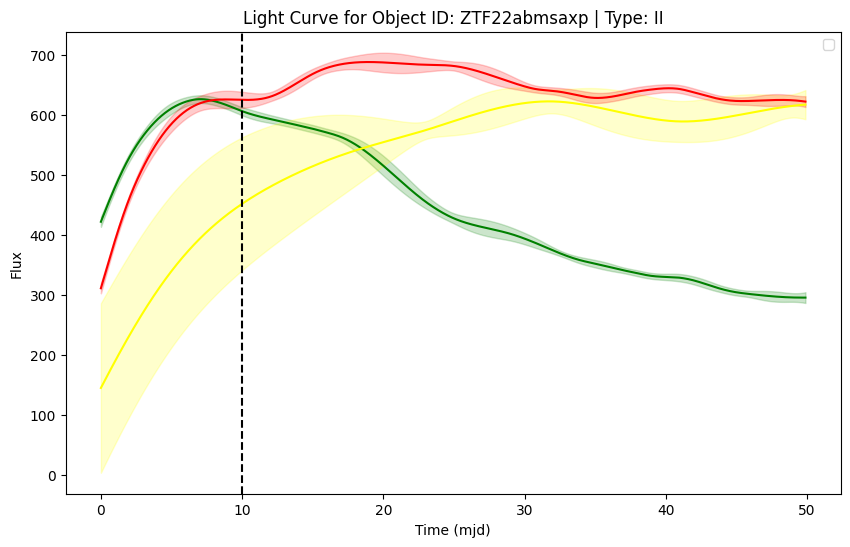

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


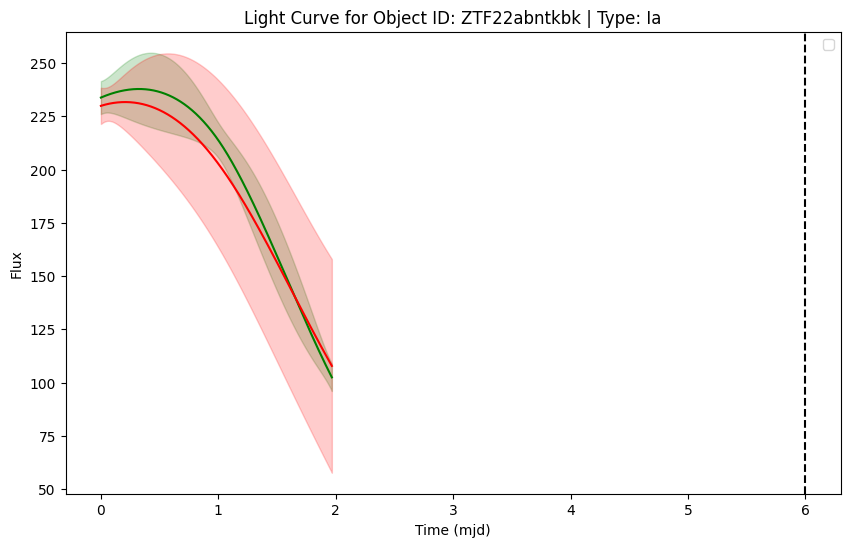

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


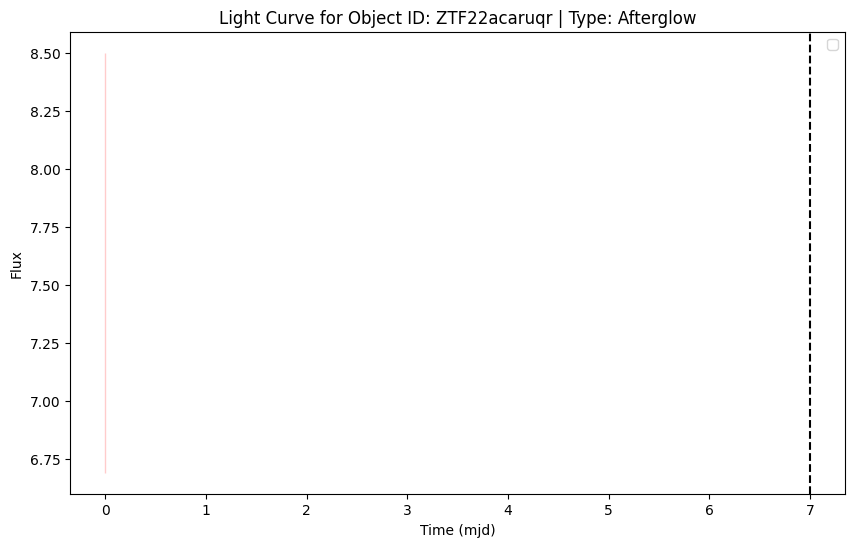

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


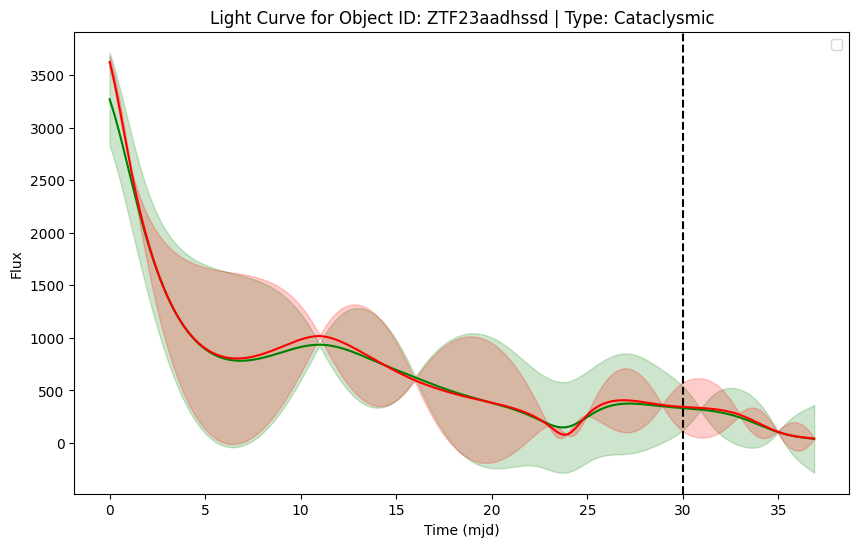

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


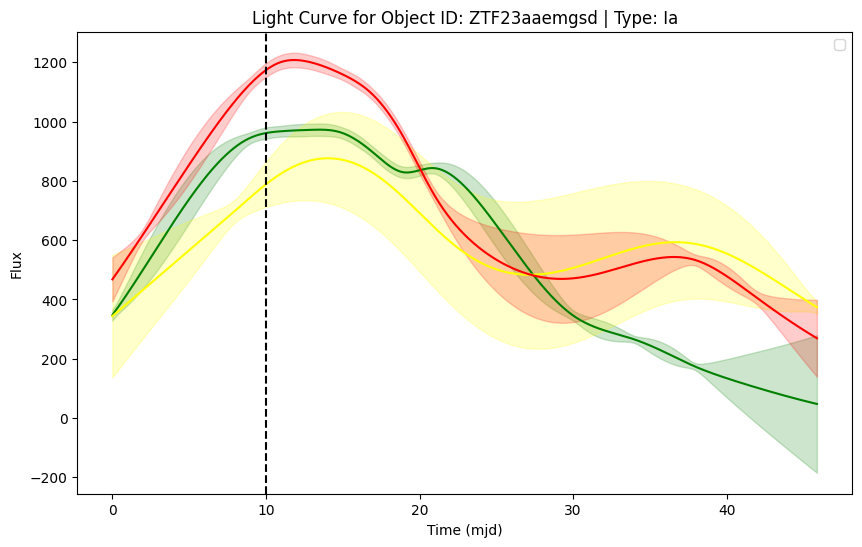

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


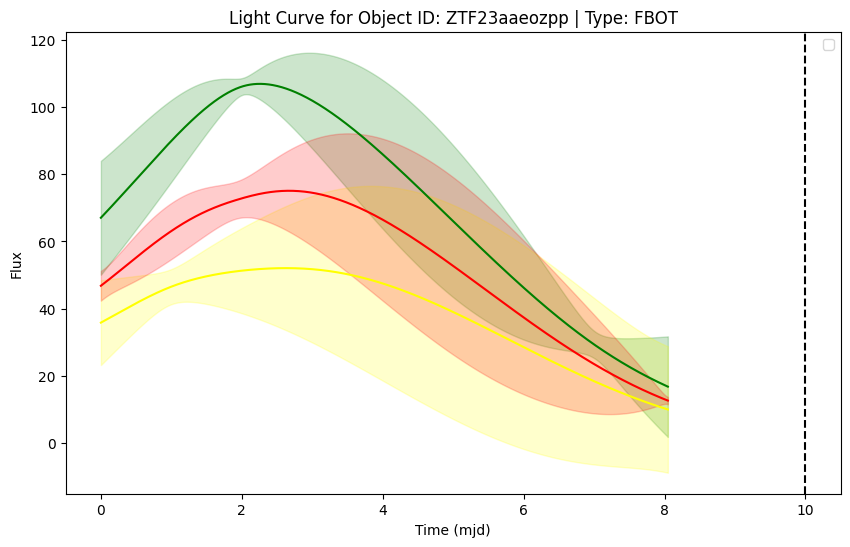

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


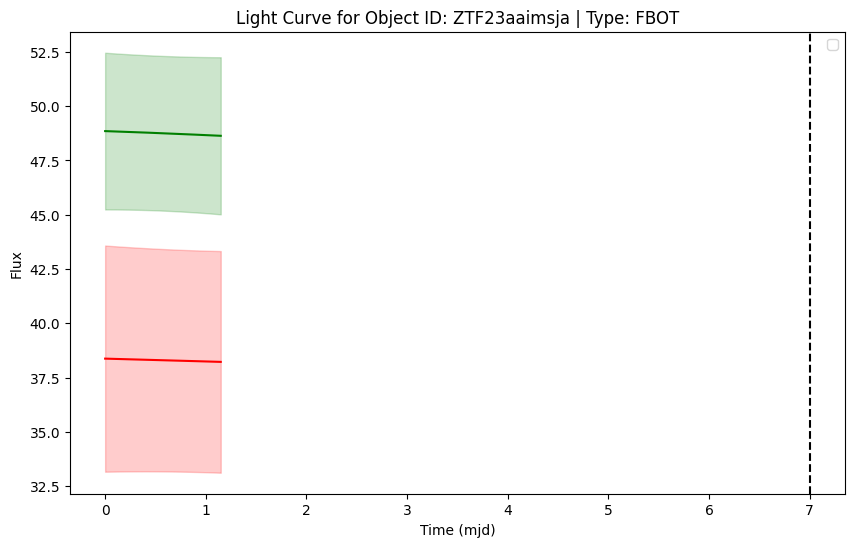

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


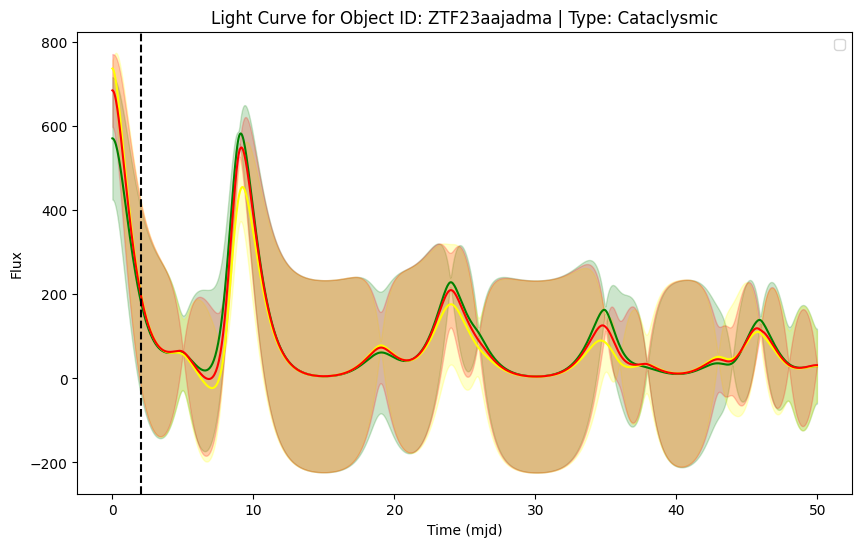

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


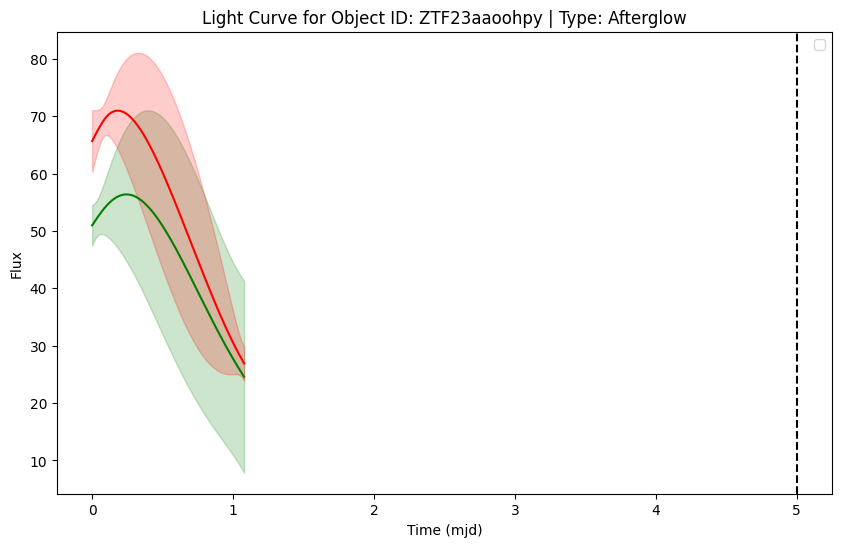

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


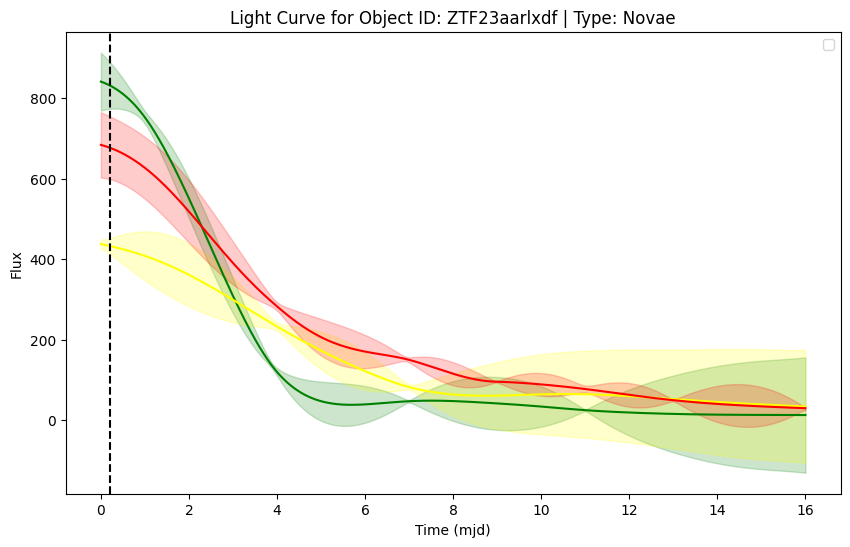

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


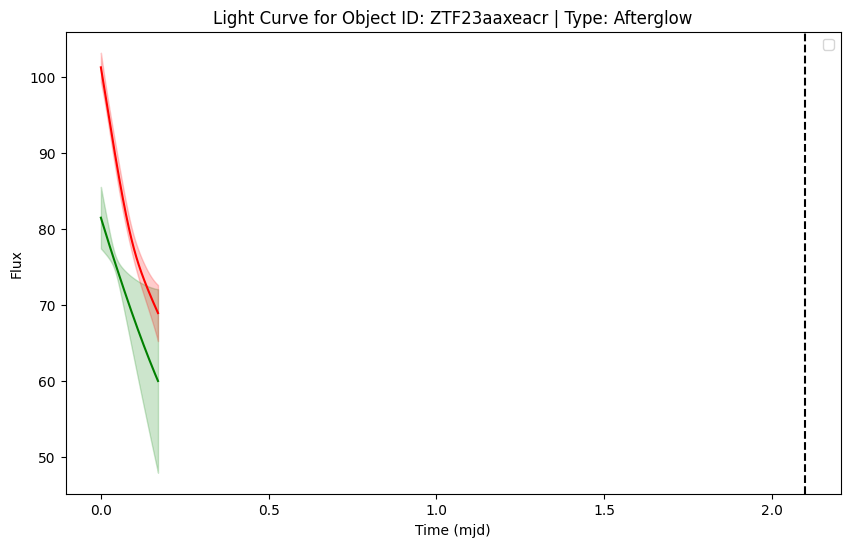

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


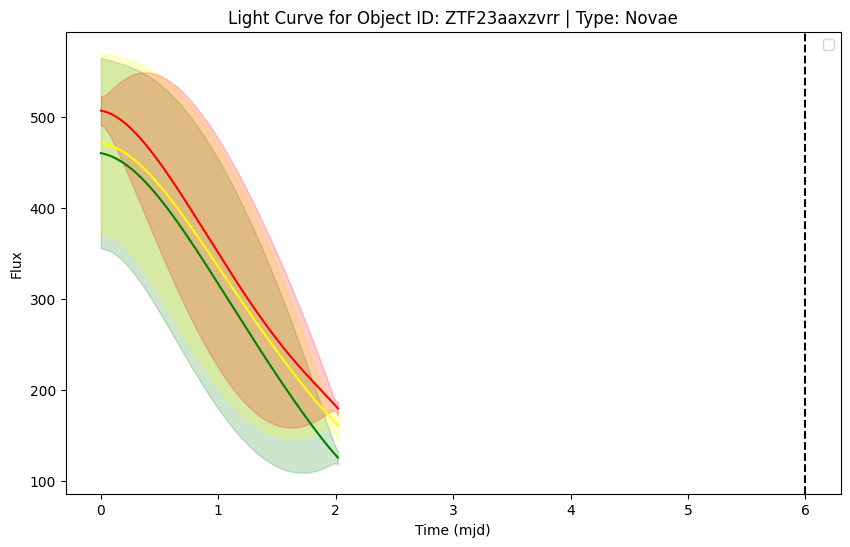

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


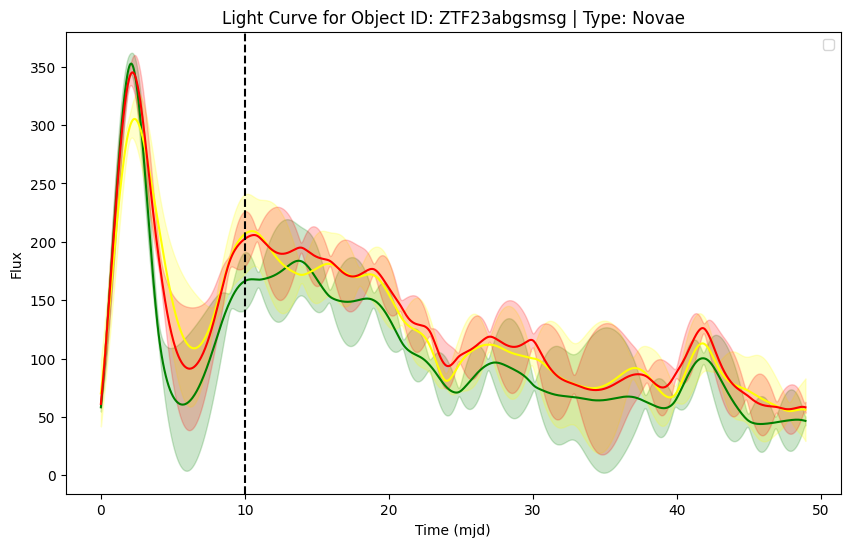

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


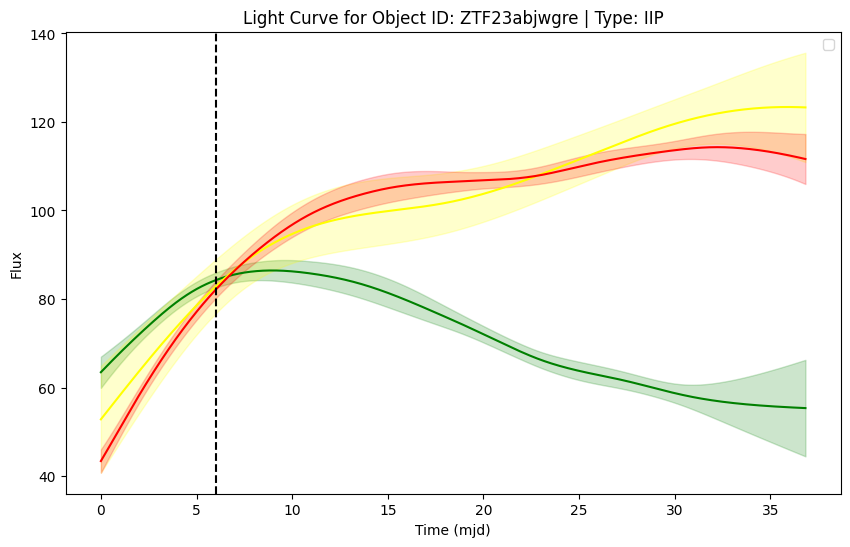

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


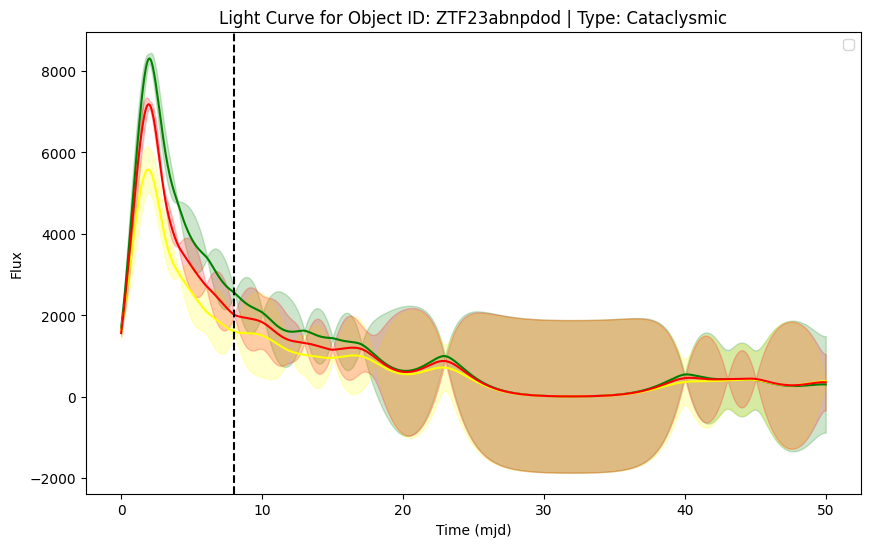

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


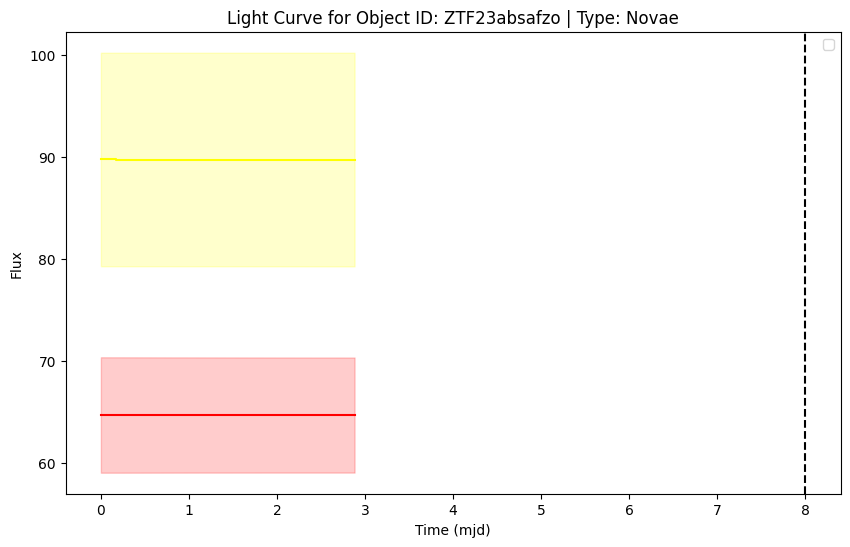

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


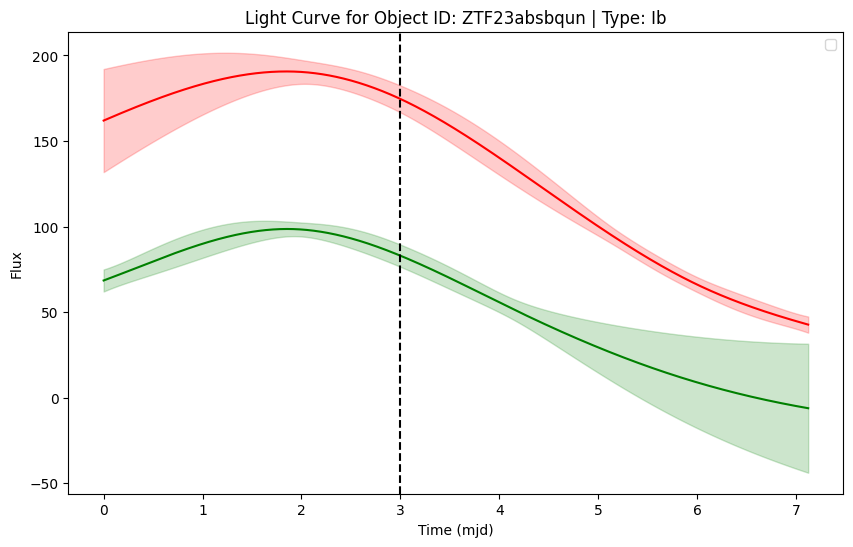

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


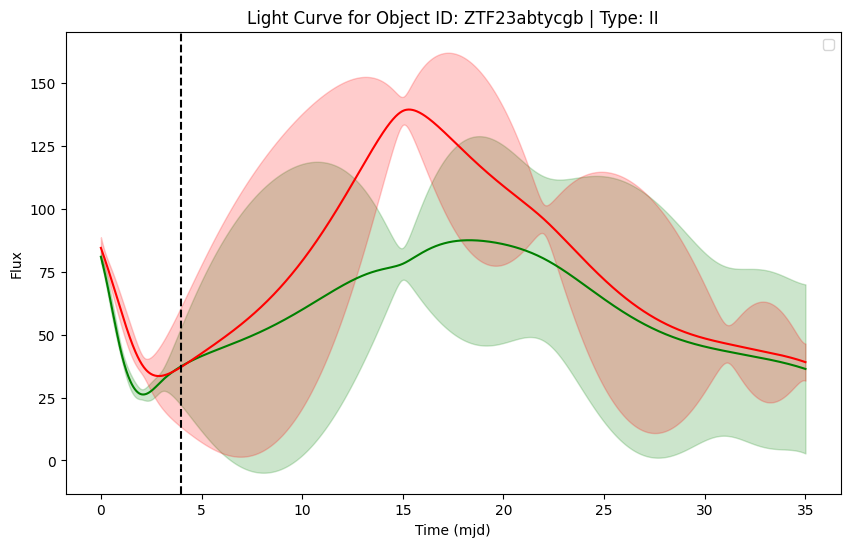

In [7]:
## really should make this less hacky
df = cut_data(df, obj[0], 10)
df = cut_data(df, obj[1], 15)
df = cut_data(df, obj[2], 7)
df = cut_data(df, obj[3], 10)
df = cut_data(df, obj[4], 12)
df = cut_data(df, obj[5], 12)
df = cut_data(df, obj[6], 23)
df = cut_data(df, obj[7], 15)
df = cut_data(df, obj[8], 12)
df = cut_data(df, obj[9], 6)
df = cut_data(df, obj[10], 3)
df = cut_data(df, obj[11], 25)
df = cut_data(df, obj[12], 11)
df = cut_data(df, obj[13], 10)
df = cut_data(df, obj[14], 20)
df = cut_data(df, obj[15], 6)
df = cut_data(df, obj[16], 10)
df = cut_data(df, obj[17], 13)
df = cut_data(df, obj[18], 20)
df = cut_data(df, obj[19], 10)
df = cut_data(df, obj[20], 25)
df = cut_data(df, obj[21], 10)
df = df[df['obj_id'] != obj[22]]  # ztfabwysqy not suited to GP
df = cut_data(df, obj[23], 25)
df = cut_data(df, obj[24], 8)
df = cut_data(df, obj[25], 35)
df = cut_data(df, obj[26], 6)
df = cut_data(df, obj[27], 5)
df = cut_data(df, obj[28], 2)
df = cut_data(df, obj[29], 10)
df = cut_data(df, obj[30], 30)
df = cut_data(df, obj[31], 8)
df = cut_data(df, obj[32], 6)
df = cut_data(df, obj[33], 4)
df = cut_data(df, obj[34], 3)
df = cut_data(df, obj[35], 6)
df = cut_data(df, obj[36], 3.1)
df = cut_data(df, obj[37], 40)
df = cut_data(df, obj[38], 7)
df = cut_data(df, obj[39], 7)
df = df[df['obj_id'] != obj[40]]  # ZTF21abhywxv not suited to GP
# df = cut_data(df, obj[40], 3)
df = cut_data(df, obj[41], 10)
df = cut_data(df, obj[42], 7)
df = cut_data(df, obj[43], 7)
df = cut_data(df, obj[44], 7)
df = cut_data(df, obj[45], 12)
df = cut_data(df, obj[46], 20)
df = cut_data(df, obj[47], 6)
df = cut_data(df, obj[48], 5)
df = cut_data(df, obj[49], 8)
df = cut_data(df, obj[50], 3)
df = cut_data(df, obj[51], 7)
df = cut_data(df, obj[52], 10)
#df = cut_data(df,obj[52], 7) ## ZTF22abntkbk was bogus, so the index shifted
df = cut_data(df,obj[53], 6)
df = df[df['obj_id'] != obj[54]]
df = cut_data(df,obj[55], 7)
df = cut_data(df,obj[56], 30)
df = cut_data(df,obj[57], 10)
df = cut_data(df,obj[58], 10)
df = df[df['obj_id'] != obj[59]]
df = cut_data(df,obj[60], 7)
df = cut_data(df,obj[61], 2)
df = cut_data(df,obj[62], 5)
df = cut_data(df,obj[63], 0.2)
df = cut_data(df,obj[64], 2.1)
df = cut_data(df,obj[65], 6)
df = cut_data(df,obj[66], 10)
df = cut_data(df,obj[67], 6)
df = cut_data(df,obj[68], 8)
df = df[df['obj_id'] != obj[69]]
df = cut_data(df,obj[70], 8)
df = cut_data(df,obj[71], 3)
df = cut_data(df,obj[72], 4)


In [8]:
df[df['obj_id'] == obj[-1]]

mjd  flux_ztfg  flux_ztfi  flux_ztfr  flux_error_ztfg  \
73001  60646.432303  36.331010        NaN  25.066002         2.034971   
73002  60646.438415  36.878915        NaN  25.505385         1.897780   
73003  60646.444527  37.431393        NaN  25.949203         1.804559   
73004  60646.450639  37.987503        NaN  26.397472         1.755290   
73005  60646.456751  38.546301        NaN  26.850209         1.748509   
...             ...        ...        ...        ...              ...   
73996  60652.513689  33.493383        NaN  40.961798         3.488673   
73997  60652.519801  33.463261        NaN  40.930338         3.842217   
73998  60652.525913  33.432509        NaN  40.895906         4.235472   
73999  60652.532025  33.401076        NaN  40.858402         4.657035   
74000  60652.538137  33.368917        NaN  40.817727         5.098662   

       flux_error_ztfi  flux_error_ztfr type        obj_id         mjd_0  ...  \
73001              NaN         3.157210  IIb  ZTF24abvevzs  60646.432303  ...   
73002              NaN         2.788540  IIb  ZTF24abvevzs  60646.432303  ...   
73003              NaN         2.448082  IIb  ZTF24abvevzs  60646.432303  ...   
73004              NaN         2.151762  IIb  ZTF24abvevzs  60646.432303  ...   
73005              NaN         1.923001  IIb  ZTF24abvevzs  60646.432303  ...   
...                ...              ...  ...           ...           ...  ...   
73996              NaN         5.252959  IIb  ZTF24abvevzs  60646.432303  ...   
73997              NaN         5.054402  IIb  ZTF24abvevzs  60646.432303  ...   
73998              NaN         4.909244  IIb  ZTF24abvevzs  60646.432303  ...   
73999              NaN         4.823773  IIb  ZTF24abvevzs  60646.432303  ...   
74000              NaN         4.802653  IIb  ZTF24abvevzs  60646.432303  ...   

        mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
73001  19.999306    -16.010249        0.060814  20.402287    -15.607268   
73002  19.983055    -16.026501        0.055872  20.383420    -15.626135   
73003  19.966910    -16.042646        0.052343  20.364690    -15.644866   
73004  19.950898    -16.058657        0.050169  20.346094    -15.663461   
73005  19.935043    -16.074512        0.049250  20.327631    -15.681925   
...          ...           ...             ...        ...           ...   
73996  20.087602    -15.921953        0.113090  19.869052    -16.140503   
73997  20.088579    -15.920976        0.124663  19.869887    -16.139669   
73998  20.089578    -15.919978        0.137549  19.870800    -16.138755   
73999  20.090599    -15.918957        0.151382  19.871797    -16.137759   
74000  20.091645    -15.917911        0.165897  19.872878    -16.136678   

       mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
73001        0.136755       NaN           NaN             NaN  0.000000  
73002        0.118705       NaN           NaN             NaN  0.006112  
73003        0.102430       NaN           NaN             NaN  0.012224  
73004        0.088503       NaN           NaN             NaN  0.018336  
73005        0.077760       NaN           NaN             NaN  0.024448  
...               ...       ...           ...             ...       ...  
73996        0.139235       NaN           NaN             NaN  6.081386  
73997        0.134075       NaN           NaN             NaN  6.087498  
73998        0.130334       NaN           NaN             NaN  6.093610  
73999        0.128183       NaN           NaN             NaN  6.099721  
74000        0.127749       NaN           NaN             NaN  6.105833  

[1000 rows x 21 columns]

In [9]:
# df = pd.read_csv('gp_objects_gp1000.csv')
rise_fade = pd.read_csv('gp_rise_fade_stats.csv')
rise_fade

Object  rise fade notes
0   ZTF18aakuewf    y    y   NaN
1   ZTF18aalrxas    y    y   NaN
2   ZTF18abffyqp    y    y   NaN
3   ZTF18abvkmgw    y    y   NaN
4   ZTF18abwkrbl    y    y   NaN
..           ...  ...  ...   ...
66  ZTF23absbqun    y    y   NaN
67  ZTF23abtycgb    n    y   NaN
68  ZTF24aascytf    y    y   NaN
69  ZTF24abvevzs    y    y   NaN
70     AT2017gfo    n    y   NaN

[71 rows x 4 columns]

In [10]:
rise_fade.columns

Index(['Object ', 'rise', 'fade', 'notes'], dtype='object')

In [11]:
# for i in rise_fade['Object ']:
#     df.loc(df['obj_id'] == i)['rise'] = rise_fade[rise_fade['Object '] == i]['rise'].values[0]
#     df.loc(df['obj_id'] == i)['fade'] = rise_fade[rise_fade['Object '] == i]['fade'].values[0]
df_array = []
for object in sorted(rise_fade['Object '].unique()):
    # print(object)
    sub_df = df[df['obj_id'] == object]
    rise = rise_fade[rise_fade['Object '] == object]['rise'].values[0]
    fade = rise_fade[rise_fade['Object '] == object]['fade'].values[0]
    df_array.append(sub_df.assign(rise=rise, fade=fade))
df = pd.concat(df_array)

In [12]:
df[df['obj_id'] == obj[-10]]

mjd   flux_ztfg   flux_ztfi   flux_ztfr  flux_error_ztfg  \
64001  60171.453472  460.275742  471.347135  506.977958       104.697654   
64002  60171.455492  460.225182  471.309024  506.935696       104.681050   
64003  60171.457513  460.173261  471.269536  506.891325       104.665728   
64004  60171.459533  460.119979  471.228671  506.844852       104.651688   
64005  60171.461553  460.065335  471.186428  506.796285       104.638927   
...             ...         ...         ...         ...              ...   
64996  60173.463540  126.650640  161.818488  180.781201         8.018363   
64997  60173.465560  126.363890  161.553429  180.483246         7.906156   
64998  60173.467580  126.078105  161.288897  180.184692         7.825391   
64999  60173.469600  125.793293  161.024885  179.885552         7.777224   
65000  60173.471620  125.509464  160.761387  179.585838         7.762442   

       flux_error_ztfi  flux_error_ztfr   type        obj_id         mjd_0  \
64001        99.335068        16.117536  Novae  ZTF23aaxzvrr  60171.453472   
64002        99.316571        16.120736  Novae  ZTF23aaxzvrr  60171.453472   
64003        99.299474        16.139790  Novae  ZTF23aaxzvrr  60171.453472   
64004        99.283777        16.174551  Novae  ZTF23aaxzvrr  60171.453472   
64005        99.269477        16.224830  Novae  ZTF23aaxzvrr  60171.453472   
...                ...              ...    ...           ...           ...   
64996        14.920692         6.647658  Novae  ZTF23aaxzvrr  60171.453472   
64997        15.245226         6.853180  Novae  ZTF23aaxzvrr  60171.453472   
64998        15.578372         7.088461  Novae  ZTF23aaxzvrr  60171.453472   
64999        15.919532         7.350522  Novae  ZTF23aaxzvrr  60171.453472   
65000        16.268143         7.636490  Novae  ZTF23aaxzvrr  60171.453472   

       ...  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
64001  ...        0.246969  17.137527      2.574292        0.034517   
64002  ...        0.246957  17.137618      2.574382        0.034527   
64003  ...        0.246949  17.137713      2.574477        0.034571   
64004  ...        0.246945  17.137812      2.574577        0.034648   
64005  ...        0.246944  17.137916      2.574681        0.034759   
...    ...             ...        ...           ...             ...   
64996  ...        0.068739  18.257117      3.693881        0.039925   
64997  ...        0.067931  18.258908      3.695672        0.041227   
64998  ...        0.067389  18.260705      3.697470        0.042713   
64999  ...        0.067126  18.262509      3.699274        0.044366   
65000  ...        0.067150  18.264320      3.701084        0.046169   

        mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  rise  fade  
64001  17.216648      2.653412        0.228816  0.000000     n     y  
64002  17.216736      2.653500        0.228792  0.002020     n     y  
64003  17.216827      2.653591        0.228771  0.004040     n     y  
64004  17.216921      2.653685        0.228755  0.006061     n     y  
64005  17.217018      2.653783        0.228743  0.008081     n     y  
...          ...           ...             ...       ...   ...   ...  
64996  18.377430      3.814194        0.100112  2.010068     n     y  
64997  18.379210      3.815974        0.102457  2.012088     n     y  
64998  18.380989      3.817753        0.104868  2.014108     n     y  
64999  18.382768      3.819532        0.107340  2.016128     n     y  
65000  18.384546      3.821310        0.109870  2.018148     n     y  

[1000 rows x 23 columns]

In [13]:
df.type.unique()

array(['Kilonova', 'Ibn', 'IIb', 'II', 'Ib', 'Ic-BL', 'Afterglow', 'Ia',
       'Novae', 'Cataclysmic', 'TDE', 'FBOT', 'IIP'], dtype=object)

In [14]:
df.obj_id.unique()

array(['AT2017gfo', 'ZTF18aakuewf', 'ZTF18aalrxas', 'ZTF18abffyqp',
       'ZTF18abvkmgw', 'ZTF18abwkrbl', 'ZTF19aanbpus', 'ZTF19aapfmki',
       'ZTF19aatesgp', 'ZTF19abacxod', 'ZTF19abxjrge', 'ZTF19abxtcio',
       'ZTF19abyjzvd', 'ZTF19acbumks', 'ZTF19accjfgv', 'ZTF20aahfqpm',
       'ZTF20aajnksq', 'ZTF20aaxhzhc', 'ZTF20aayrobw', 'ZTF20aazchcq',
       'ZTF20abstsxb', 'ZTF20aburywx', 'ZTF20abwzqzo', 'ZTF20acgigfo',
       'ZTF20acgiglu', 'ZTF20acigusw', 'ZTF20aclfmwn', 'ZTF20acozryr',
       'ZTF20acqntkr', 'ZTF20actqnhg', 'ZTF21aaabrpu', 'ZTF21aaabwfu',
       'ZTF21aabxjqr', 'ZTF21aagwbjr', 'ZTF21aapkbav', 'ZTF21aaqzrat',
       'ZTF21abbvvmf', 'ZTF21abexegc', 'ZTF21abfmpwn', 'ZTF21aciosfu',
       'ZTF22aaajecp', 'ZTF22aabjpxh', 'ZTF22aahgvlx', 'ZTF22aaibbvy',
       'ZTF22aajrrzz', 'ZTF22aayluxo', 'ZTF22aazmooy', 'ZTF22abfjnpj',
       'ZTF22abfxmpc', 'ZTF22abijszk', 'ZTF22abmsaxp', 'ZTF22abntkbk',
       'ZTF23aadhssd', 'ZTF23aaemgsd', 'ZTF23aaeozpp', 'ZTF23aajadma',
       'Z

In [15]:
df.to_csv('gp_objects(downsample).csv', index=False)